In [1]:
!pip install osmnx
!pip install mapclassify
!pip install geopy
!pip install alphashape
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd
from geopandas import overlay
import contextily as ctx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import pandas as pd
import mapclassify
import folium
import matplotlib
import geopy.distance
import numpy as np
from shapely.ops import unary_union
import geemap
import shapely.wkt
from alphashape import alphashape
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, MultiPoint, Point
import pickle
from shapely.ops import transform
import pyproj

Mounted at /content/drive


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

# Straßennetzwerke direkt über Stadtname laden

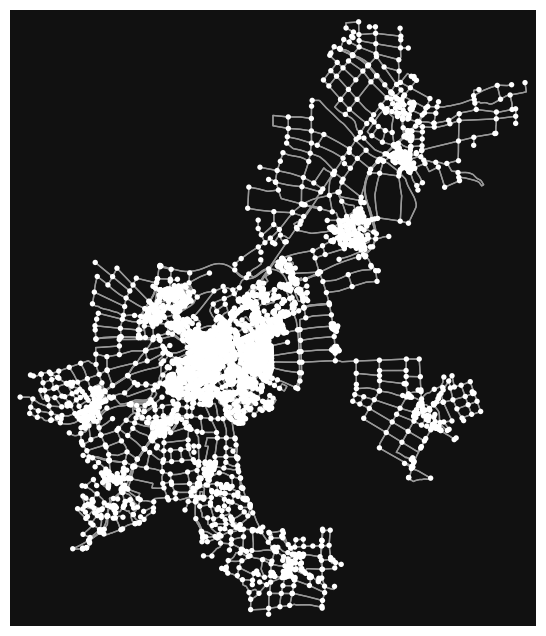

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Noerdlingen = ox.graph_from_place('Noerdlingen, Germany', network_type='walk')
ox.plot_graph(G_Noerdlingen)

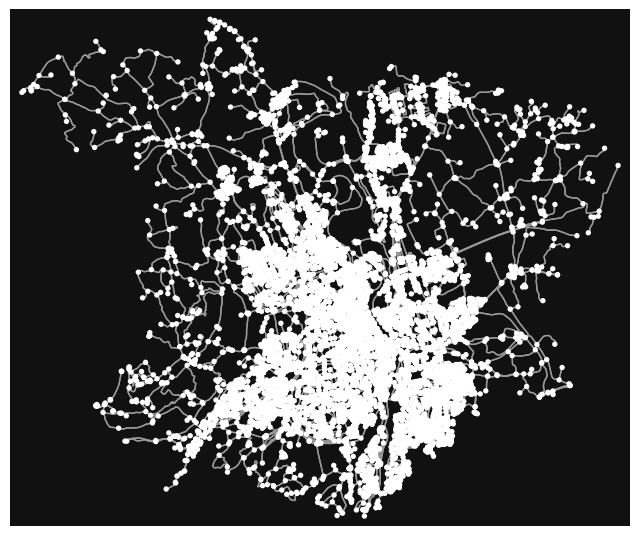

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Kempten = ox.graph_from_place('Kempten, Germany', network_type='walk')
ox.plot_graph(G_Kempten)

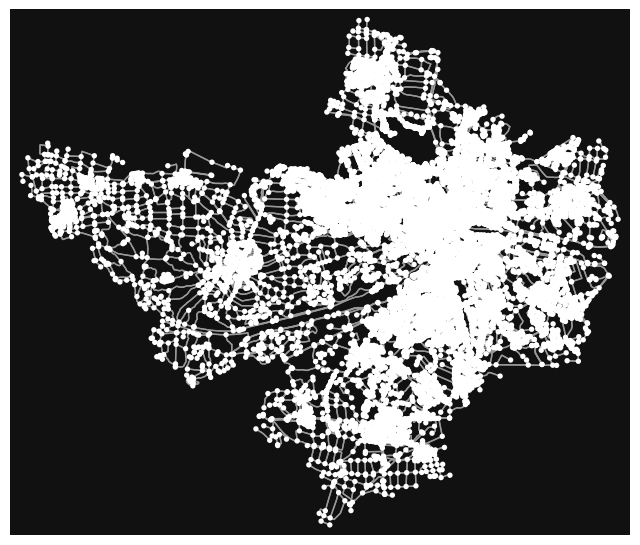

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Ingolstadt = ox.graph_from_place('Ingolstadt, Germany', network_type='walk')
ox.plot_graph(G_Ingolstadt)

In [ ]:
# Speichern der Netzwerke im GraphML-Format
ox.save_graphml(G_Noerdlingen, filepath='noerdlingen_strassennetz.graphml')
ox.save_graphml(G_Kempten, filepath='kempten_strassennetz.graphml')
ox.save_graphml(G_Ingolstadt, filepath='ingolstadt_strassennetz.graphml')

In [ ]:
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')

In [ ]:
# Definiere die Pfade zu den GraphML-Dateien
graphml_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml",
]

# Definiere die Pfade für die GeoPackages
geopackage_files = [
    "Wegenetz_Noerdlingen.gpkg",
    "Wegenetz_Kempten.gpkg",
    "Wegenetz_Ingolstadt.gpkg",
]

# Schleife durch die GraphML-Dateien und speichere sie als GeoPackages
for i, graphml_file in enumerate(graphml_files):
    # Lade den Graphen aus der GraphML-Datei
    G = ox.load_graphml(graphml_file)
    # Speichere den Graphen als GeoPackage
    ox.io.save_graph_geopackage(G, filepath=geopackage_files[i])
    print(f"Graph aus {graphml_file} als {geopackage_files[i]} gespeichert.")

Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml als Wegenetz_Noerdlingen.gpkg gespeichert.
Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml als Wegenetz_Kempten.gpkg gespeichert.
Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml als Wegenetz_Ingolstadt.gpkg gespeichert.


Cold-Spots Polygone laden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


In [ ]:
print(cold_spot_Ingolstadt.crs)
print(cold_spot_Kempten.head(10))
print(cold_spot_Noerdlingen.head(10))

EPSG:4326
                                            geometry
0  MULTIPOINT (10.25144 47.71334, 10.25144 47.713...
                                            geometry
0  MULTIPOINT (10.44089 48.80938, 10.44116 48.806...


nearest nodes von osmnx: Zentroid Methode hier nicht sinnvoll, bringt ungenaues Ergebnis bei unsymmetrischen, langgestreckten Cold Spots

deshalb: Linienbasierte Erreichbarkeitsanalyse mit Grenze der Polygone als Ausgangslinie

ausgehend von den gruppierten Cold Spots (dissolved_Noerdlingen,...) für jeden Cold Spot eine linienbasierte Erreichbarkeitsanalyse durchführen: entlang der Grenzen der Cold Spots in regelmäßigen Abständen (50 m) eine Reihe von Ausgangspunkten generieren

 Für jeden dieser Punkte wird der nächstgelegene Knoten im Fußgängernetzwerk (G_Noerdlingen,...) bestimmt. Anschließend wird für jeden dieser Startknoten eine Isochrone (Erreichbarkeitszone) für 5, 10 und 15 Minuten berechnet – bei einer Gehgeschwindigkeit von 1 m/s entspricht das 300, 600 bzw. 900 m. Zum Schluss werden für jeden Cold Spot die Isochronen der einzelnen Startpunkte pro Zeitlimit vereinigt.

überlappende Polygone sollen als ein feature gesehen werden, und alleinstehende ebenso als eines: dafür: nach überlappungen suchen, diese dann zusammenführen und schließlich jedem Cold Spot eine Cluster ID hinzufügen (um überlappende als Gruppe zu sehen), um schließlich die Geometrien zu vereinigen

dafür vorher noch: POINTS (Cold Spots) in Polygone umwandeln => mit buffer Befehl (100m, weil Landsat Pixel auch 100m Auflösung haben)

# Service Areas für Nördlingen, Kempten und Ingolstadt

Cold Spots gruppieren, sodass überlappende als einer gesehen werden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


In [ ]:
def cluster_cold_spots(gdf):
    """
    Gruppiert Cold Spots basierend auf Überschneidungen und weist Cluster-IDs zu.

    Args:
        gdf: GeoDataFrame mit Cold Spot-Geometrien.

    Returns:
        GeoDataFrame mit zusätzlicher Spalte 'cluster_id'.
    """

    # Kopie des GeoDataFrames erstellen
    gdf_clustered = gdf.copy().reset_index(drop=True)

    # Geometrien umwandeln
    gdf_clustered = gdf_clustered.to_crs(epsg=32632)

    # Explodiere MultiPolygone in einzelne Polygone und setze den Index neu
    gdf_clustered = gdf_clustered.explode(index_parts=True).reset_index(drop=True)

    # Überprüfen, ob es sich um Punkte handelt und diese in Polygone umwandeln
    if gdf_clustered.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
        buffer_distance = 100  # 100m, weil Landsat Pixel auch 100m Auflösung haben
        print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
        gdf_clustered['geometry'] = gdf_clustered.geometry.buffer(buffer_distance)

    # --- Aufbau des Graphen zur Cluster-Bildung ---
    G = nx.Graph()
    for idx in gdf_clustered.index:
        G.add_node(idx)

    sindex = gdf_clustered.sindex
    for idx, geom in gdf_clustered.geometry.items():
        possible_matches_index = list(sindex.intersection(geom.bounds))
        for other_idx in possible_matches_index:
            if idx < other_idx:
                # Hier wird überprüft, ob sich die Polygone überschneiden
                if geom.intersects(gdf_clustered.loc[other_idx, 'geometry']):
                    G.add_edge(idx, other_idx)

    clusters = list(nx.connected_components(G))
    print("Gefundene Cluster:", clusters)

    # Mapping: Jeder ursprüngliche Index erhält eine Cluster-ID
    cluster_mapping = {}
    for cluster_id, component in enumerate(clusters):
        for idx in component:
            cluster_mapping[idx] = cluster_id

    gdf_clustered['cluster_id'] = gdf_clustered.index.map(cluster_mapping)

    # Polygone innerhalb des gleichen Clusters zusammenführen
    gdf_dissolved = gdf_clustered.dissolve(by='cluster_id', aggfunc='first') # 'first' behält die Attribute des ersten Features bei

    # Geometrie in Polygon oder MultiPolygon umwandeln (falls nötig)
    gdf_dissolved['geometry'] = gdf_dissolved['geometry'].apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)

    return gdf_dissolved

# Wende die Funktion auf die Cold Spot-Dateien an
cold_spot_Ingolstadt = cluster_cold_spots(cold_spot_Ingolstadt)
cold_spot_Kempten = cluster_cold_spots(cold_spot_Kempten)
cold_spot_Noerdlingen = cluster_cold_spots(cold_spot_Noerdlingen)

# Speichere die bearbeiteten Dateien
cold_spot_Ingolstadt.to_file("Ingolstadt_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Kempten.to_file("Kempten_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Noerdlingen.to_file("Noerdlingen_ColdSpots_clustered.geojson", driver="GeoJSON")

Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}]


geclusterte(gruppierte Cold Spots laden)

In [ ]:
cold_spots_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson")
cold_spots_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson")
cold_spots_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson")

In [ ]:
cold_spots_Kempten = cold_spots_Kempten.to_crs(epsg=4326)
cold_spots_Ingolstadt = cold_spots_Ingolstadt.to_crs(epsg=4326)
cold_spots_Noerdlingen = cold_spots_Noerdlingen.to_crs(epsg=4326)

In [ ]:
print("Ingolstadt:")
print(cold_spots_Ingolstadt)

print("\nKempten:")
print(cold_spots_Kempten)

print("\nNördlingen:")
print(cold_spots_Noerdlingen)

Ingolstadt:
    cluster_id                                           geometry
0            0  POLYGON ((11.27742 48.75987, 11.27732 48.75992...
1            1  POLYGON ((11.29031 48.7643, 11.29018 48.76433,...
2            2  POLYGON ((11.31796 48.73853, 11.31785 48.73858...
3            3  POLYGON ((11.31149 48.74985, 11.31138 48.7499,...
4            4  POLYGON ((11.31253 48.73464, 11.3124 48.73464,...
5            5  POLYGON ((11.31646 48.74665, 11.31642 48.74657...
6            6  POLYGON ((11.31673 48.72771, 11.31661 48.72775...
7            7  POLYGON ((11.31603 48.73652, 11.3159 48.73652,...
8            8  POLYGON ((11.36051 48.7301, 11.36039 48.73013,...
9            9  POLYGON ((11.3698 48.74274, 11.36968 48.74277,...
10          10  POLYGON ((11.37277 48.70771, 11.37264 48.70773...
11          11  POLYGON ((11.37616 48.72895, 11.37606 48.72889...
12          12  POLYGON ((11.38044 48.71092, 11.38031 48.71092...
13          13  POLYGON ((11.41847 48.75213, 11.41837 48.75207..

In [ ]:
cold_spots_Kempten.to_csv("Kempten_ColdSpots_clustered.csv", index=False)
cold_spots_Ingolstadt.to_csv("Ingolstadt_ColdSpots_clustered.csv", index=False)
cold_spots_Noerdlingen.to_csv("Noerdlingen_ColdSpots_clustered.csv", index=False)

umwandeln in shapefile (um ggf in qgis zu verwenden)

In [ ]:
# Definiere den Pfad für die Ausgabedatei (Shapefile)
shapefile_Noerdlingen = "ColdSpots_Noerdlingen.shp"
shapefile_Kempten = "ColdSpots_Kempten.shp"
shapefile_Ingolstadt = "ColdSpots_Ingolstadt.shp"

# Dateien lesen
Kempten_gdf = cold_spots_Kempten
Noerdlingen_gdf = cold_spots_Noerdlingen
Ingolstadt_gdf = cold_spots_Ingolstadt

# Funktion zum Zuweisen und Umwandeln der Geometriespalte
def assign_and_convert_geometry(gdf):
    """Weist die Geometriespalte zu und konvertiert sie in den richtigen Geometrietyp."""
    gdf.geometry = gdf.geometry.apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)
    gdf.geometry = gpd.GeoSeries(gdf.geometry, crs=gdf.crs)
    gdf = gpd.GeoDataFrame(gdf[['cluster_id', 'geometry']], geometry='geometry', crs=gdf.crs) # 'geometry' und 'cold_spot_id' durch die tatsächlichen Spaltennamen ersetzen, falls abweichend
    gdf = gdf.reset_index(drop=True)
    return gdf

# Anwendung der Funktion und Schreiben in Shapefiles
Noerdlingen_gdf = assign_and_convert_geometry(Noerdlingen_gdf)
Noerdlingen_gdf.to_file(shapefile_Noerdlingen, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Noerdlingen.geojson", driver="GeoJSON")

Kempten_gdf = assign_and_convert_geometry(Kempten_gdf)
Kempten_gdf.to_file(shapefile_Kempten, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Kemoten.geojson", driver="GeoJSON")

Ingolstadt_gdf = assign_and_convert_geometry(Ingolstadt_gdf)
Ingolstadt_gdf.to_file(shapefile_Ingolstadt, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Ingolstadt.geojson", driver="GeoJSON")

print(f"GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.")


GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.


Verwendung in QGIS funktioniert nicht! Attributtabelle von Shapefile (auch von geojson) zeigt geometry spalte nicht an, obwohl Datentyp stimmt...

# Visualisieren

neuer Versuch: Schnittpunkte zwischen Graphen und ColdSpot Außenlinie finden und zu Startpunkten für Erreichbarkeitsanalyse machen

In [ ]:
# Cold Spots
cold_spots_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson")
cold_spots_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson")
cold_spots_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson")

# Wegenetze

G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')


In [ ]:
# Definiere eine Liste mit den GeoDataFrames der Cold Spots für jede Stadt
staedte_cold_spots = [cold_spots_Noerdlingen, cold_spots_Kempten, cold_spots_Ingolstadt]

# Definiere eine Liste mit den Stadtnamen
stadt_namen = ["Noerdlingen", "Kempten", "Ingolstadt"]

# Schleife über die Städte und GeoDataFrames
for i, cold_spots_stadt in enumerate(staedte_cold_spots):
    # Konvertiere die Polygone in Linien
    cold_spots_stadt['geometry'] = cold_spots_stadt['geometry'].boundary

    # Gebe den Stadtnamen und die aktualisierte Geometrie aus
    print(f"Cold Spots in {stadt_namen[i]} wurden in Linien konvertiert.")

Cold Spots in Noerdlingen wurden in Linien konvertiert.
Cold Spots in Kempten wurden in Linien konvertiert.
Cold Spots in Ingolstadt wurden in Linien konvertiert.


In [ ]:
# Schleife über die Städte und GeoDataFrames
for stadt_name, cold_spots_stadt in zip(stadt_namen, staedte_cold_spots):
    print(f"Geometrie der Cold Spots in {stadt_name}:")
    print(cold_spots_stadt['geometry'])  # Hier wird die Geometriespalte ausgegeben

print(cold_spots_Ingolstadt.crs)
print(cold_spots_Noerdlingen.crs)
print(cold_spots_Kempten.crs)

Geometrie der Cold Spots in Noerdlingen:
0     LINESTRING (605760.66 5406884.279, 605752.778 ...
1     LINESTRING (605957.16 5411542.938, 605949.889 ...
2     LINESTRING (606347.855 5407669.364, 606339.438...
3     LINESTRING (607021.088 5407652.256, 607012.671...
4     LINESTRING (607413.381 5410794.311, 607403.673...
5     LINESTRING (607589.46 5409868.712, 607579.753 ...
6     LINESTRING (607629.629 5413437.244, 607620.109...
7     LINESTRING (608456.674 5409643.441, 608455.234...
8     LINESTRING (608921.452 5409569.092, 608912.212...
9     LINESTRING (609159.157 5407059.943, 609150.286...
10    LINESTRING (609702.418 5413086.419, 609692.711...
11    LINESTRING (610438.456 5405848.326, 610428.654...
12    LINESTRING (611355.148 5412127.848, 611353.708...
13    LINESTRING (611639.101 5411724.035, 611630.229...
14    LINESTRING (612343.617 5412641.604, 612335.2 5...
15    LINESTRING (612880.005 5417832.636, 612871.133...
16    LINESTRING (613316.992 5411330.595, 613307.284...
17    L

erfolgreich in Linien konvertiert, jetzt nach Schnittpunkten suchen

In [ ]:
from shapely.ops import transform
import pyproj
from functools import partial


In [ ]:
def find_intersection_points(cold_spots_gdf, graph):
    """
    Findet Schnittpunkte zwischen den Linien der Cold Spots und dem Wegenetz des Graphen.

    Args:
        cold_spots_gdf: GeoDataFrame mit den Cold Spot Linien.
        graph: OSMnx Graph-Objekt.

    Returns:
        GeoDataFrame mit den Schnittpunkten als Punkte.
    """

    # Ensure cold_spots_gdf is in WGS 84 (epsg:4326)
    if cold_spots_gdf.crs != 'epsg:4326':
        cold_spots_gdf = cold_spots_gdf.to_crs('epsg:4326')

    # Project the graph to UTM Zone 32N (epsg:32632)
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')

    # Extract the edges of the graph as a GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False, edges=True)

    # Project cold_spots_gdf to UTM Zone 32N (epsg:32632) for intersection calculation
    cold_spots_gdf_proj = cold_spots_gdf.to_crs('epsg:32632')

    # Create a list to store the intersection points
    intersection_points = []

    # Iterate over the Cold Spot lines
    for cold_spot_line in cold_spots_gdf_proj['geometry']:
        # Iterate over the edges of the graph
        for edge_line in edges['geometry']:
            # Check if the lines intersect
            if cold_spot_line.intersects(edge_line):
                # Calculate the intersection point
                intersection = cold_spot_line.intersection(edge_line)

                # Filter only points (no lines or polygons)
                if intersection.geom_type == 'Point':
                    # Add the point to the list
                    intersection_points.append(intersection)
                elif intersection.geom_type == 'MultiPoint':
                    # If it's a MultiPoint, add each point individually
                    for point in intersection.geoms:
                        intersection_points.append(point)

    # Create a GeoDataFrame from the intersection points
    intersection_gdf = gpd.GeoDataFrame(geometry=intersection_points, crs=cold_spots_gdf_proj.crs)  # Use projected CRS

    # Convert back to WGS 84 (epsg:4326) if needed
    # intersection_gdf = intersection_gdf.to_crs('epsg:4326')

    return intersection_gdf

# für jede Stadt
intersection_points_Noerdlingen = find_intersection_points(cold_spots_Noerdlingen, G_Noerdlingen)
intersection_points_Kempten = find_intersection_points(cold_spots_Kempten, G_Kempten)
intersection_points_Ingolstadt = find_intersection_points(cold_spots_Ingolstadt, G_Ingolstadt)

In [ ]:
print(intersection_points_Noerdlingen.count())
print(intersection_points_Noerdlingen.crs)

geometry    142
dtype: int64
epsg:32632


visueller Check

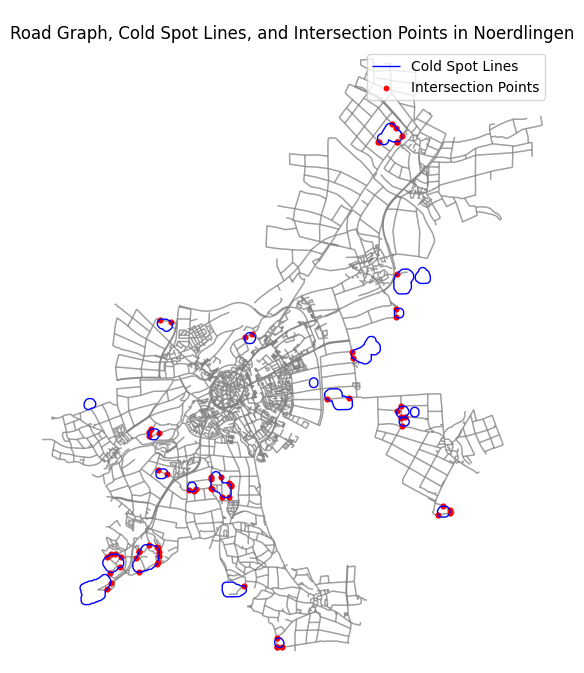

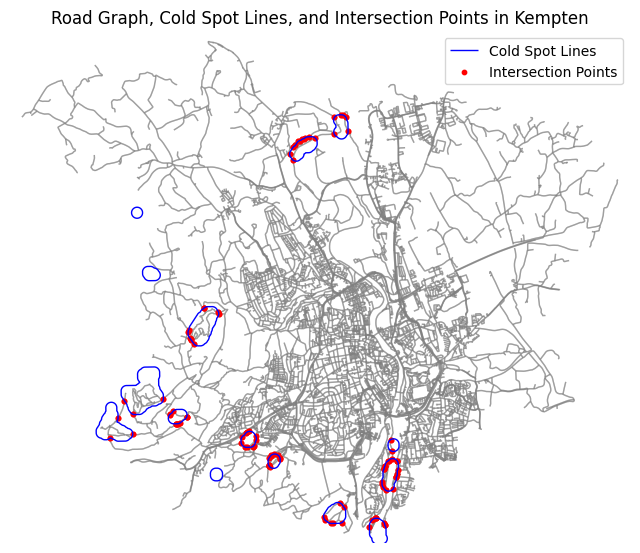

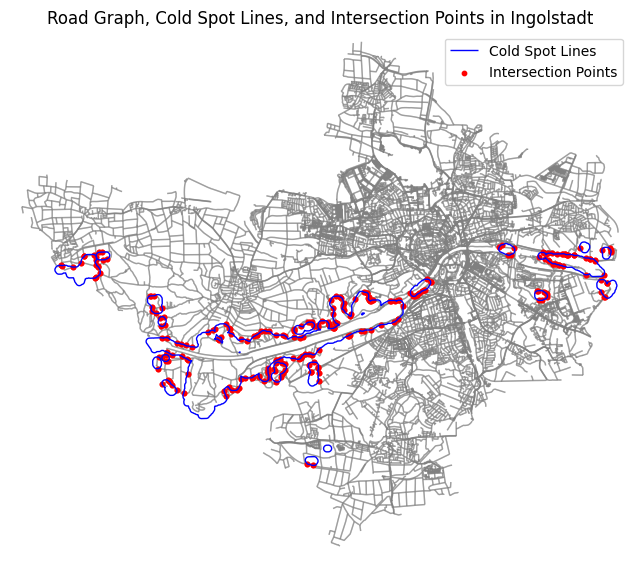

In [ ]:
# Function to plot for a single city
def plot_city_data(graph, cold_spots_gdf, intersection_points_gdf, city_name):
    """Plots the road graph, Cold Spot lines, and intersection points for a city."""

    # Project the graph and Cold Spots to the same CRS (UTM Zone 32N)
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')
    cold_spots_gdf_proj = cold_spots_gdf.to_crs('epsg:32632')

    # Create figure and axes
    fig, ax = ox.plot_graph(graph_proj, show=False, close=False, node_size=0,
                           edge_color='gray', edge_alpha=0.5, bgcolor='white')

    # Plot Cold Spot lines
    cold_spots_gdf_proj.plot(ax=ax, color='blue', linewidth=1, label='Cold Spot Lines')

    # Plot intersection points
    intersection_points_gdf.plot(ax=ax, color='red', markersize=10, marker='o', label='Intersection Points')

    # Set title and legend
    ax.set_title(f"Road Graph, Cold Spot Lines, and Intersection Points in {city_name}")
    ax.legend()

    # Show plot
    plt.show()

# Plot for each city
plot_city_data(G_Noerdlingen, cold_spots_Noerdlingen, intersection_points_Noerdlingen, "Noerdlingen")
plot_city_data(G_Kempten, cold_spots_Kempten, intersection_points_Kempten, "Kempten")
plot_city_data(G_Ingolstadt, cold_spots_Ingolstadt, intersection_points_Ingolstadt, "Ingolstadt")

ausgehend von den intersection_points für jede Stadt service Area Analysen:

Reisekosten/Gehgeschwindigkeit: 1m/s, Erreichbarkeit für 5, 10, 15 und 20 Minuten

 Service Area Analyse soll zunächst nur die zu erreichbaren Straßenabschnitte liefern. Diese dann mit den cold_spot_xStadt Daten verknüpfen, um insbesondere das Feld Cluster ID aus den cold spot Daten, den Straßenabschnitts-Daten hinzuzufügen, um: anschließend anhand des Feldes cluster id, minimale begrenzende Geometrie (konvexe Hülle), auf die Straßenabschnitte anwenden

In [ ]:
# Parameter festlegen
walk_speed = 1  # Gehgeschwindigkeit in m/s (entspricht ca. 5 km/h)
time_thresholds = [300, 600, 900, 1200]  # 5, 10, 15 und 20 Minuten in Sekunden

# Funktion zur Durchführung der Service Area Analyse und Verknüpfung mit Cold Spot Daten
def service_area_analysis(graph, intersection_points_gdf, cold_spot_data, city_name):
    """
    Führt die Service Area Analyse durch, verknüpft die Ergebnisse mit Cold Spot Daten
    und erstellt konvexe Hüllen basierend auf Cluster-IDs.
    """

    # Projiziere den Graphen in UTM Zone 32N
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')

    # Füge die 'travel_time' Attribut zu den Kanten hinzu
    for u, v, key, data in graph_proj.edges(keys=True, data=True):
        data['travel_time'] = data.get('length', 0) / walk_speed

    # Projiziere den Cold Spot GeoDataFrame in die gleiche Projektion wie der Graph
    cold_spot_data_proj = cold_spot_data.to_crs(graph_proj.graph['crs'])

    # Ergebnisse für alle Zeitlimits speichern
    all_results = []

    # Schleife über alle Zeitlimits
    for time_limit in time_thresholds:
        print(f"--- Verarbeitung von {city_name}, {time_limit / 60:.0f} Minuten ---")

        # Ergebnisse für dieses Zeitlimit speichern
        results = []

        # Schleife über alle Schnittpunkte
        for idx, row in intersection_points_gdf.iterrows():
            # Finde den nächstgelegenen Knoten zum Schnittpunkt
            nearest_node = ox.distance.nearest_nodes(graph_proj, X=row.geometry.x, Y=row.geometry.y)

            # Berechne die Isochrone (erreichbare Knoten)
            subgraph = nx.ego_graph(graph_proj, nearest_node, radius=time_limit, distance='travel_time')

            # Add a check for edges in the subgraph
            if not subgraph.edges:
            # Handle cases where the subgraph has no edges:
            # 1. Skip this point and continue with the next one
            # 2. Set the service area for this point to None (or an empty geometry)
            # 3. Use a different method to estimate the service area (e.g., buffering)
              print(f"Subgraph has no edges for intersection point {idx}, skipping...")
              continue  # Skip to the next intersection point


            # Extrahiere die Kanten der Isochrone als GeoDataFrame
            edges_isochrone = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)
            edges_isochrone['time_threshold'] = time_limit / 60  # Zeitlimit in Minuten hinzufügen

            # Füge die Ergebnisse zur Liste hinzu
            results.append(edges_isochrone)

        # Verknüpfe alle Ergebnisse für dieses Zeitlimit
        all_edges_isochrone = gpd.GeoDataFrame(pd.concat(results, ignore_index=True), crs=edges_isochrone.crs)

        # Verknüpfe die Ergebnisse mit den Cold Spot Daten
        joined_data = gpd.sjoin(all_edges_isochrone, cold_spot_data_proj, how='left', predicate='intersects')

        # Stellen Sie sicher, dass 'index_right' in der joined_data vorhanden ist
        joined_data = joined_data[~joined_data['index_right'].isnull()]

        # Gruppiere nach Cluster-ID und erstelle konvexe Hüllen
        # Verwende 'index_right' (die ursprünglichen Indexwerte von cold_spot_data_proj) für die Gruppierung
        convex_hulls = joined_data.groupby('index_right')['geometry'].apply(lambda x: unary_union(x).convex_hull)

        # Füge die konvexen Hüllen zu den Ergebnissen hinzu,
        # indem Sie mit den ursprünglichen Indexwerten von cold_spot_data_proj die cluster_id abrufen
        joined_data['cluster_id'] = joined_data['index_right'].map(cold_spot_data_proj['cluster_id'])  # Assuming 'cluster_id' is the column name
        joined_data[f'convex_hull_{time_limit / 60:.0f}min'] = joined_data['index_right'].map(convex_hulls)

        all_results.append(joined_data)

    # Verbinde alle Ergebnisse aus allen Zeitlimits
    final_result = gpd.GeoDataFrame(pd.concat(all_results, ignore_index=True), crs=all_results[0].crs)

    return final_result

# --- Durchführung der Analyse für jede Stadt ---
Noerdlingen_service_areas = service_area_analysis(G_Noerdlingen, intersection_points_Noerdlingen, cold_spots_Noerdlingen, "Noerdlingen")
Kempten_service_areas = service_area_analysis(G_Kempten, intersection_points_Kempten, cold_spots_Kempten, "Kempten")
Ingolstadt_service_areas = service_area_analysis(G_Ingolstadt, intersection_points_Ingolstadt, cold_spots_Ingolstadt, "Ingolstadt")

# --- Speichern der Ergebnisse ---
#Noerdlingen_service_areas.to_file("Noerdlingen_service_areas.gpkg", driver="GPKG")
#Kempten_service_areas.to_file("Kempten_service_areas.gpkg", driver="GPKG")
#Ingolstadt_service_areas.to_file("Ingolstadt_service_areas.gpkg", driver="GPKG")

--- Verarbeitung von Noerdlingen, 5 Minuten ---
Subgraph has no edges for intersection point 95, skipping...
Subgraph has no edges for intersection point 97, skipping...
Subgraph has no edges for intersection point 134, skipping...
Subgraph has no edges for intersection point 136, skipping...
Subgraph has no edges for intersection point 138, skipping...
Subgraph has no edges for intersection point 140, skipping...
--- Verarbeitung von Noerdlingen, 10 Minuten ---
Subgraph has no edges for intersection point 95, skipping...
Subgraph has no edges for intersection point 97, skipping...
--- Verarbeitung von Noerdlingen, 15 Minuten ---
--- Verarbeitung von Noerdlingen, 20 Minuten ---
--- Verarbeitung von Kempten, 5 Minuten ---
Subgraph has no edges for intersection point 37, skipping...
Subgraph has no edges for intersection point 40, skipping...
Subgraph has no edges for intersection point 50, skipping...
Subgraph has no edges for intersection point 51, skipping...
--- Verarbeitung von Kemp

Verarbeitung knapp 7 min. Man könnte weniger Punkte nehmen wenn mehr Städte,...

In [ ]:
print(Kempten_service_areas.head(30))

                   osmid       highway  oneway reversed      length  \
0   [27868660, 27868695]         track   False     True  176.979238   
1   [27868660, 27868695]         track   False    False  176.979238   
2   [27868660, 27868695]         track   False     True  176.979238   
3   [27868660, 27868695]         track   False    False  176.979238   
4               61834876         track   False     True   37.442314   
5   [54725494, 54725495]         track   False    False  167.397895   
6               61834876         track   False    False   37.442314   
7   [54725494, 54725495]         track   False     True  167.397895   
8               61834876         track   False     True   37.442314   
9   [54725494, 54725495]         track   False    False  167.397895   
10              61834876         track   False    False   37.442314   
11  [54725494, 54725495]         track   False     True  167.397895   
12              54701460  unclassified   False    False  269.584867   
13    

=> entweder verknüpfung oder Erstellung der konvexen hüllen klappt nicht richtig...

Plotten der Ergebnisse:

<ipython-input-132-6be6fbde7a3e>:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


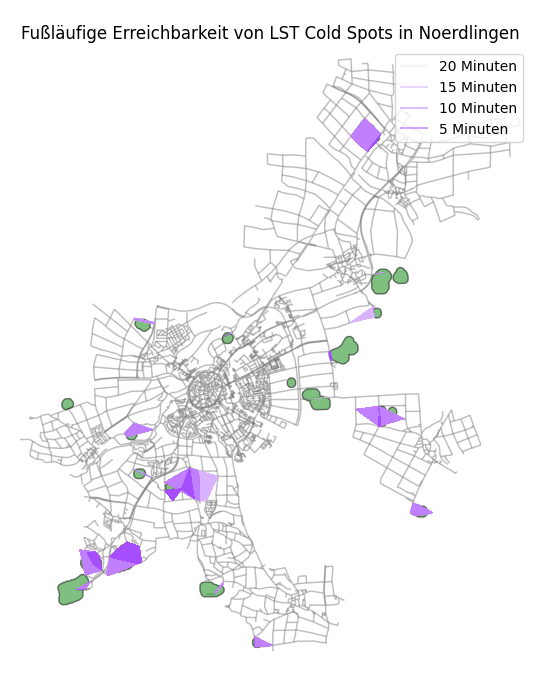

<ipython-input-132-6be6fbde7a3e>:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
<ipython-input-132-6be6fbde7a3e>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


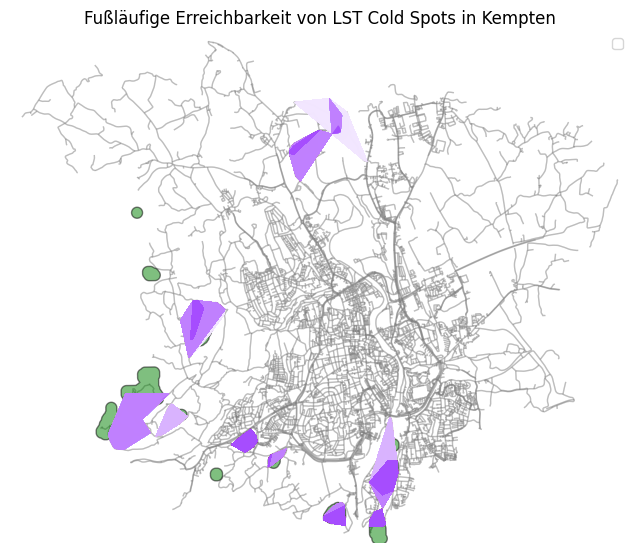

<ipython-input-132-6be6fbde7a3e>:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
<ipython-input-132-6be6fbde7a3e>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


KeyboardInterrupt: 

In [ ]:
# Definiere die Farben für die Erreichbarkeitszonen (dunkler werdendes Lila)
colors = ['#f2e6ff', '#d9b3ff', '#c080ff', '#a64dff']

# Definiere die Pfade zu den GraphML-Dateien und Cold Spot GeoJSON-Dateien
graphml_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml",
]
cold_spot_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson",
]
city_names = ["Noerdlingen", "Kempten", "Ingolstadt"]

# Liste der Service Areas für jede Stadt
service_areas_list = [Noerdlingen_service_areas, Kempten_service_areas, Ingolstadt_service_areas]


# Schleife über die Städte
for graphml_file, cold_spot_file, city_name, service_areas in zip(graphml_files, cold_spot_files, city_names, service_areas_list):
    # Lade den Graphen und die Cold Spot Daten
    graph = ox.load_graphml(graphml_file)
    cold_spots = gpd.read_file(cold_spot_file)

    # Projiziere den Graphen und die Cold Spots in UTM Zone 32N
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')
    cold_spots_proj = cold_spots.to_crs(graph_proj.graph['crs'])

    # Erstelle eine Figure und ein Axes-Objekt
    fig, ax = ox.plot_graph(graph_proj, show=False, close=False, node_size=0,
                           edge_color='gray', edge_alpha=0.3, bgcolor='white')  # Straßennetz schwach hinterlegt

    # Plotte die Cold Spots als Polygone
    cold_spots_proj.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label='Cold Spots')

    # Plotte die Erreichbarkeitszonen (konvexe Hüllen)
    for i, time_threshold in enumerate(reversed([300, 600, 900, 1200])):  # 20, 15, 10, 5 Minuten
        # Filtere die Erreichbarkeitszonen (konvexe Hüllen) für das aktuelle Zeitlimit
        filtered_service_areas = service_areas[service_areas['time_threshold'] == time_threshold / 60]

        # Extrahiere die konvexen Hüllen
        convex_hulls = filtered_service_areas['convex_hull'].dropna() # Entferne fehlende Werte

        # Plotte die konvexen Hüllen
        convex_hulls.plot(ax=ax, color=colors[i], alpha=0.5, edgecolor='none', label=f'{time_threshold / 60:.0f} Minuten')

    # Setze den Titel und die Legende
    ax.set_title(f"Fußläufige Erreichbarkeit von LST Cold Spots in {city_name}")
    ax.legend()

    # Zeige den Plot
    plt.show()

alte Methode (extrem zeitintensiv) Punkte im Abstand von x (hier 5) Metern an Außenlinie der Polygone gelten als Startpunkte => nearest nodes => Erreichbarkeit 5, 10, 15 Minuten

--- Verarbeitung von Noerdlingen ---
--- Noerdlingen abgeschlossen ---


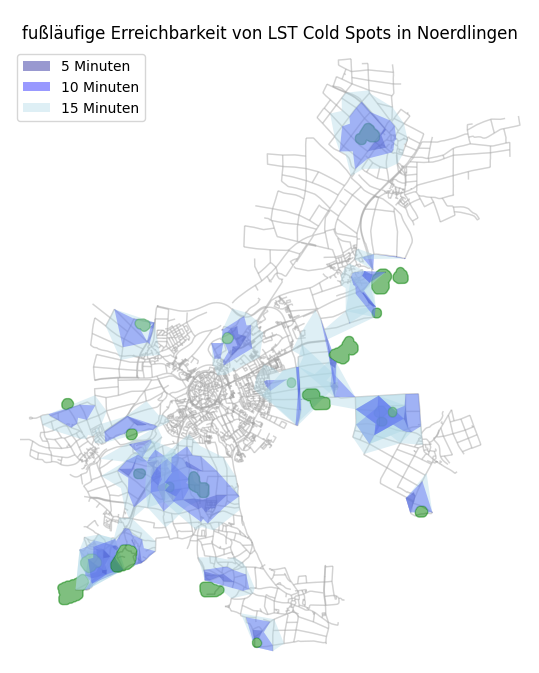

--- Verarbeitung von Kempten ---
--- Kempten abgeschlossen ---


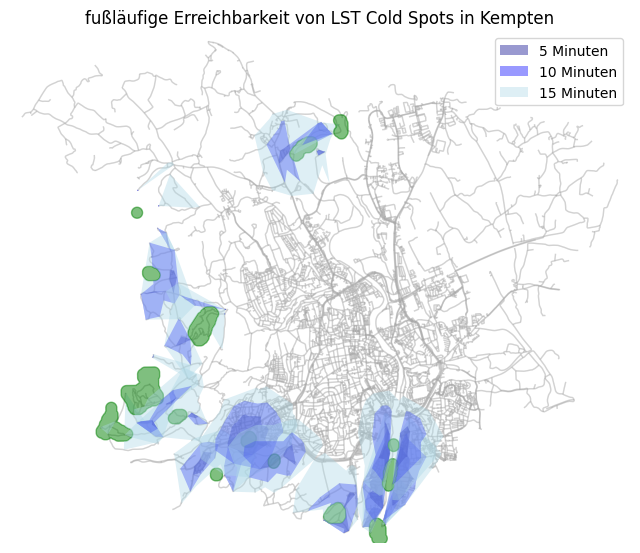

--- Verarbeitung von Ingolstadt ---
--- Ingolstadt abgeschlossen ---


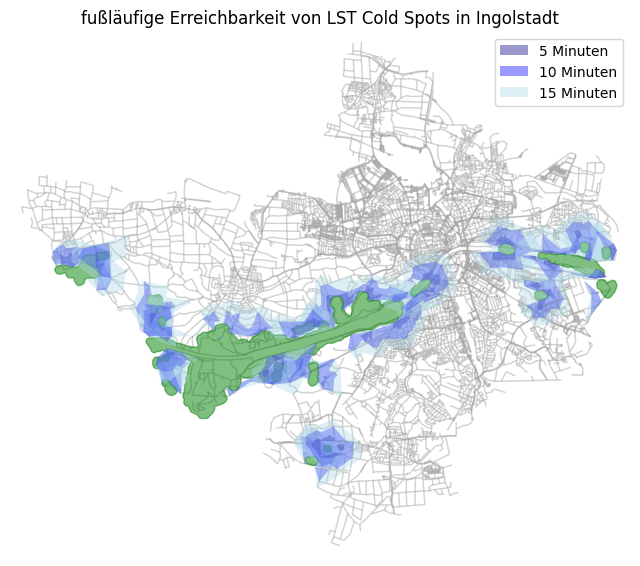

In [ ]:
# Parameter festlegen
walk_speed = 1  # Gehgeschwindigkeit in m/s (entspricht ca. 5 km/h)
time_thresholds = [300, 600, 900]  # 5, 10 und 15 Minuten in Sekunden
colors = {300: 'darkblue', 600: 'blue', 900: 'lightblue'}
point_interval = 5  # Abstand der Punkte entlang der Außenlinie in Metern


def sample_points_on_line(line, interval):
    """Erzeugt Punkte entlang einer LineString-Geometrie in regelmäßigen Abständen."""
    distances = np.arange(0, line.length, interval)
    points = [line.interpolate(distance) for distance in distances]
    return points


# Schleife über die Städte und Cold Spots
for stadt, cold_spot_data, graph in [("Noerdlingen", cold_spot_Noerdlingen, G_Noerdlingen),
                                    ("Kempten", cold_spot_Kempten, G_Kempten),
                                    ("Ingolstadt", cold_spot_Ingolstadt, G_Ingolstadt)]:
    print(f"--- Verarbeitung von {stadt} ---")

    # Projiziere den Graphen in UTM Zone 32N
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')

    # Füge die 'travel_time' Attribut zu den Kanten hinzu
    for u, v, key, data in graph_proj.edges(keys=True, data=True):
        data['travel_time'] = data.get('length', 0) / walk_speed

    # Projiziere den Cold Spot GeoDataFrame in die gleiche Projektion wie der Graph
    cold_spot_data_proj = cold_spot_data.to_crs(graph_proj.graph['crs'])

    # --- Hier wird der results-Dictionary initialisiert ---
    results = []

    # Erstelle eine Figure und ein Axes-Objekt vor der Schleife
    fig, ax = ox.plot_graph(graph_proj, show=False, close=False, node_size=0,
                           edge_color='darkgray', edge_alpha=0.3, bgcolor='white')

    # Legende-Handles und Labels - Initialisieren Sie sie hier, aber fügen Sie sie später hinzu
    legend_handles = []
    legend_labels = []

    # Schleife über alle Cold Spots der Stadt
    for idx, row in cold_spot_data_proj.iterrows():
        cold_spot_polygon = row.geometry

        # Zeichne den Cold Spot als Polygon
        x, y = cold_spot_polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='green', ec='green', label="Cold Spot")  # Zeichne Cold Spot hier

        # Erzeuge Punkte entlang der Außenlinie des Cold Spots
        boundary_line = cold_spot_polygon.boundary
        boundary_points = sample_points_on_line(boundary_line, point_interval)

        # Isochronen für jedes Zeitlimit speichern
        isochrones_per_threshold = {thresh: [] for thresh in time_thresholds}

        # Berechne die Erreichbarkeiten von den Punkten entlang der Außenlinie
        for point in boundary_points:
            # Finde den nächstgelegenen Knoten zum Punkt
            nearest_node = ox.distance.nearest_nodes(graph_proj, X=point.x, Y=point.y)

            # Berechne die Isochronen für die Zeitlimits, aber nur außerhalb des Cold Spots
            for time_limit in time_thresholds:
                subgraph = nx.ego_graph(graph_proj, nearest_node, radius=time_limit, distance='travel_time')
                node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)
                               if not cold_spot_polygon.contains(Point(data['x'], data['y']))]  # Nur Punkte außerhalb

                # Wenn weniger als 3 Punkte erreichbar sind, verwende den nächstgelegenen Knotenpunkt
                if len(node_points) < 3:
                    polygon = Point(graph_proj.nodes[nearest_node]['x'], graph_proj.nodes[nearest_node]['y']).buffer(10)
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen
                else:
                    polygon = unary_union(node_points).convex_hull
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen

                isochrones_per_threshold[time_limit].append(polygon)  # Isochrone speichern

       # --- Hier wird das Ergebnis an den results-Dictionary angehängt ---
        results.append({
            'cold_spot_id': idx,
            'geometry': cold_spot_polygon,  # Originalgeometrie des Cold Spots
            'service_5min': unary_union(isochrones_per_threshold[300]) if isochrones_per_threshold[300] else None,
            'service_10min': unary_union(isochrones_per_threshold[600]) if isochrones_per_threshold[600] else None,
            'service_15min': unary_union(isochrones_per_threshold[900]) if isochrones_per_threshold[900] else None
        })

        # Isochronen für jedes Zeitlimit zusammenführen und zeichnen
        for time_limit in time_thresholds:
            # Alle Isochronen für dieses Zeitlimit zu einer einzigen Geometrie zusammenführen
            merged_isochrone = unary_union(isochrones_per_threshold[time_limit])

            # Zeichne die zusammengeführte Isochrone, berücksichtige MultiPolygon
            if merged_isochrone.geom_type == 'Polygon':
                x, y = merged_isochrone.exterior.xy
                handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            elif merged_isochrone.geom_type == 'MultiPolygon':
                for polygon in merged_isochrone.geoms:  # Iteriere durch die Polygone im MultiPolygon
                    x, y = polygon.exterior.xy
                    handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            else:
                # Handle other geometry types if necessary
                pass

            # Füge Handle und Label zur Legende hinzu (nur einmal pro Zeitlimit)
            label = f'{time_limit / 60:.0f} Minuten'
            if label not in legend_labels:
                legend_handles.append(handle[0])  # Assuming handle is a list
                legend_labels.append(label)


    # --- Speichern des results-Dictionarys als Pickle-Datei ---
    with open(f'service_area_results_{stadt}.pickle', 'wb') as f:
        pickle.dump(results, f)

    # --- Erstellen und Speichern des GeoDataFrames ---
    service_area_gdf = gpd.GeoDataFrame(results, crs=cold_spot_data_proj.crs)
    service_area_gdf.to_file(f"service_area_gdf_{stadt}.geojson", driver="GeoJSON")

    print(f"--- {stadt} abgeschlossen ---")

    # Setze den Titel und die Legende für den Plot - außerhalb der Schleife
    ax.set_title(f"fußläufige Erreichbarkeit von LST Cold Spots in {stadt}")
    ax.legend(handles=legend_handles, labels=legend_labels)
    plt.show()  # Zeige den Plot außerhalb der Schleife

In [ ]:
#pickle-Dateien (mit results) laden
with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Ingolstadt.pickle", 'rb') as f:
    results_Ingolstadt = pickle.load(f)
    print(results_Ingolstadt)

with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Kempten.pickle", 'rb') as f:
    results_Kempten = pickle.load(f)
    print(results_Kempten)

with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Noerdlingen.pickle", 'rb') as f:
    results_Noerdlingen = pickle.load (f)
    print(results_Noerdlingen)

[{'cold_spot_id': 0, 'geometry': <POLYGON ((667370.175 5403263.678, 667362.293 5403269.524, 667355.021 540327...>, 'service_5min': <MULTIPOLYGON (((666906.834 5403822.138, 666932.424 5403779.626, 667027.57 5...>, 'service_10min': <POLYGON ((666916.811 5404047.346, 666963.066 5404064.178, 667013.375 540412...>, 'service_15min': <POLYGON ((667408.4 5403595.662, 667401.448 5403596.003, 667391.646 5403595....>}, {'cold_spot_id': 1, 'geometry': <POLYGON ((668301.879 5403785.293, 668292.36 5403787.677, 668283.12 5403790....>, 'service_5min': <MULTIPOLYGON (((668237.34 5403968.882, 668232.295 5403960.465, 668228.099 5...>, 'service_10min': <POLYGON ((668195.833 5403485.082, 667672.99 5403854.021, 667815.199 5404118...>, 'service_15min': <POLYGON ((667464.032 5403822.966, 667528.922 5404101.462, 668218.228 540421...>}, {'cold_spot_id': 2, 'geometry': <POLYGON ((670421.19 5400981.927, 670412.773 5400986.972, 670404.89 5400992....>, 'service_5min': <MULTIPOLYGON (((670221.775 5400845.539, 670307

In [ ]:
# Convert results to GeoDataFrame and set CRS
results_Ingolstadt = gpd.GeoDataFrame(results_Ingolstadt, crs="epsg:4326")  # Assuming your data is in EPSG:4326
results_Kempten = gpd.GeoDataFrame(results_Kempten, crs="epsg:4326")
results_Noerdlingen = gpd.GeoDataFrame(results_Noerdlingen, crs="epsg:4326")

# Now you can print the CRS
print(results_Ingolstadt.crs)

epsg:4326


graph ml Datei aufbereiten für QGIS


In [ ]:
# Graph aus der GraphML-Datei laden
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')


# save graph as a geopackage
ox.io.save_graph_geopackage(G_Noerdlingen, filepath="Wegenetz_Noerdlingen.gpkg")
ox.io.save_graph_geopackage(G_Kempten, filepath="Wegenetz_Kempten.gpkg")
ox.io.save_graph_geopackage(G_Ingolstadt, filepath="Wegenetz_Ingolstadt.gpkg")

# verknüpfen mit Bevölkerungsdaten

wieviel Prozent der jeweiligen Bevölkerungsgruppen erreichen cold spots innerhalb von 5, 10 und 15 Minuten?

welche Bevölkerungsgruppen leben tendenziell näher an Cold Spots, gibt es da überhaupt Muster?




In [ ]:
alle_staedte_cluster = pd.read_csv('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster.csv')


In [ ]:
print(alle_staedte_cluster.head())

                   GITTER_ID_100m  x_mp_100m  y_mp_100m  \
0  CRS3035RES100mN2854400E4359000    4359050    2854450   
1  CRS3035RES100mN2854500E4358400    4358450    2854550   
2  CRS3035RES100mN2854500E4358700    4358750    2854550   
3  CRS3035RES100mN2854500E4358800    4358850    2854550   
4  CRS3035RES100mN2854500E4358900    4358950    2854550   

                  geometry  AnteilUeber65  AnteilAuslaender  \
0  POINT (4359050 2854450)            NaN               NaN   
1  POINT (4358450 2854550)            NaN               NaN   
2  POINT (4358750 2854550)            NaN               NaN   
3  POINT (4358850 2854550)          13.64               NaN   
4  POINT (4358950 2854550)            NaN               NaN   

   durchschnFlaechejeBew  Durchschnittsalter  Einwohner  durchschnMieteQM  \
0                  65.00               37.13          3               NaN   
1                    NaN               53.48          3               NaN   
2                  39.04           

Punkte in Gitterzellen umwandeln und so visualisieren

In [ ]:
Noerdlingen_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/NOERDLINGEN_neu_merged.csv")
Kempten_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/KEMPTEN_neu_merged_2.csv")
Ingolstadt_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/INGOLSTADT_neu_merged_2.csv")

In [ ]:
alle_staedte_cluster = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster.csv')
# Definiere das Koordinatensystem, falls es nicht in der CSV-Datei enthalten ist:
alle_staedte_cluster.crs = 'epsg:3035'

# Convert 'x_mp_100m' and 'y_mp_100m' columns to numeric
alle_staedte_cluster['x_mp_100m'] = pd.to_numeric(alle_staedte_cluster['x_mp_100m'])
alle_staedte_cluster['y_mp_100m'] = pd.to_numeric(alle_staedte_cluster['y_mp_100m'])

def create_grid_cell(row):
    """Erstellt ein Polygon (Rechteck) basierend auf den Koordinaten des Mittelpunkts."""
    x = row['x_mp_100m']
    y = row['y_mp_100m']
    # Erstelle die Eckpunkte des Rechtecks:
    # Annahme: x und y sind in einem projizierten Koordinatensystem, wo die Einheiten Meter sind
    p1 = (x - 50, y + 50)  # Links oben
    p2 = (x + 50, y + 50)  # Rechts oben
    p3 = (x + 50, y - 50)  # Rechts unten
    p4 = (x - 50, y - 50)  # Links unten
    # Erstelle das Polygon:
    polygon = Polygon([p1, p2, p3, p4])
    return polygon

#Create geometry column. This will convert the DataFrame to a GeoDataFrame.
alle_staedte_cluster['geometry'] = alle_staedte_cluster.apply(create_grid_cell, axis=1)
#Setting the crs to make sure it's a GeoDataFrame. This was previously set after reading the file.
alle_staedte_cluster = gpd.GeoDataFrame(alle_staedte_cluster, geometry='geometry', crs='epsg:3035')

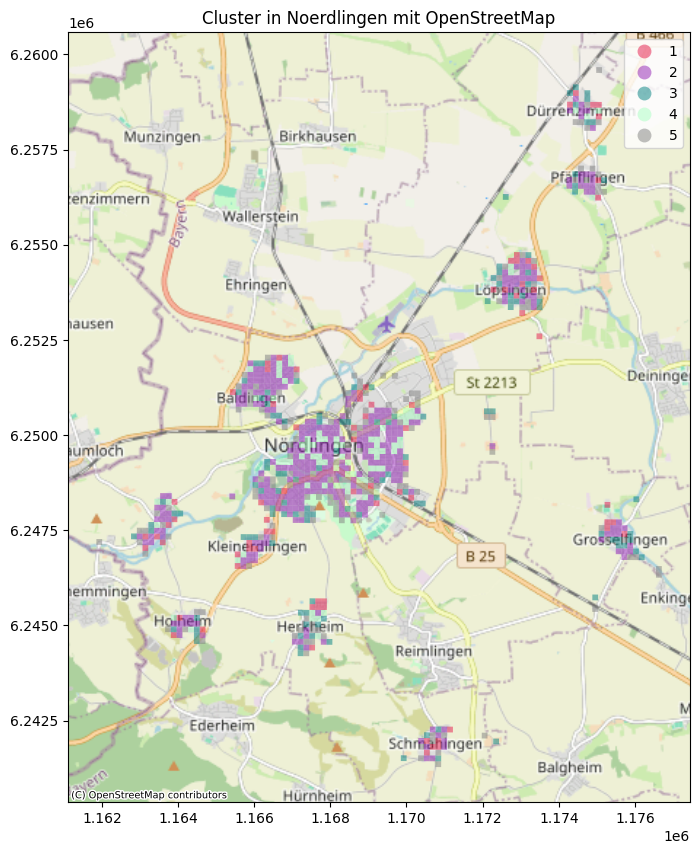

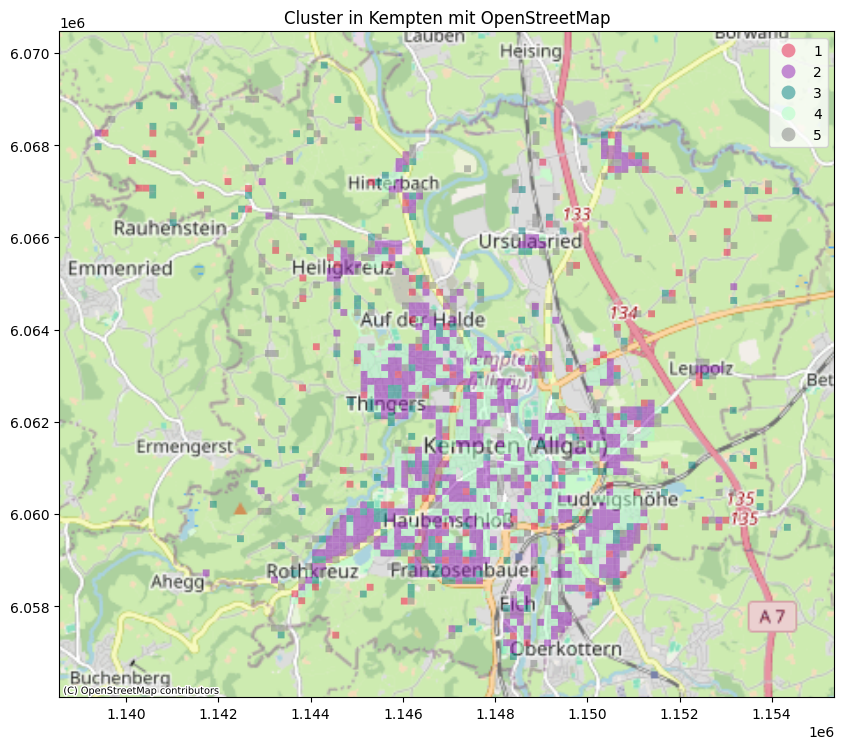

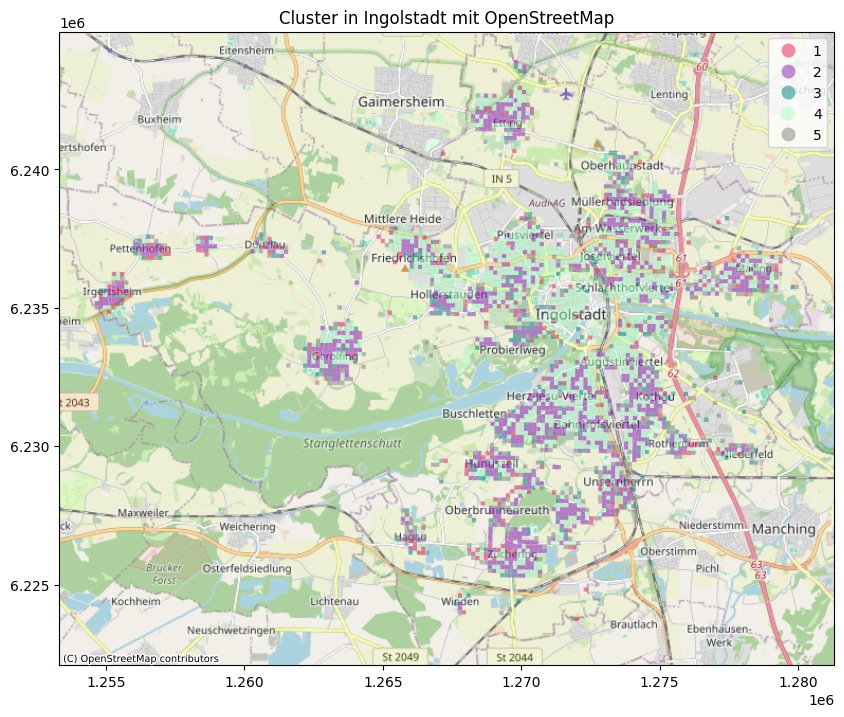

In [ ]:
# Annahme: Noerdlingen_df, Kempten_df, Ingolstadt_df und alle_staedte_cluster sind bereits geladen

# Definiere das CRS für die Basemap (z.B. Web Mercator)
basemap_crs = "EPSG:3857"

# Erstelle ein Dictionary, das die Gitter-IDs den Städten zuordnet
stadt_gitter_ids = {}
for stadt_df, stadt_name in [(Noerdlingen_df, "Noerdlingen"), (Kempten_df, "Kempten"), (Ingolstadt_df, "Ingolstadt")]:
    stadt_gitter_ids[stadt_name] = stadt_df["GITTER_ID_100m"].unique().tolist()

# Definiere die Basemap-Provider
basemap_providers = {
    "OpenStreetMap": ctx.providers.OpenStreetMap.Mapnik,
}

# Definiere eine Liste mit eindeutigen Farben
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                   '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                   '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                   '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

# Schleife über die Städte und Basemap-Provider
for stadt_name, gitter_ids in stadt_gitter_ids.items():
    for provider_name, provider_source in basemap_providers.items():
        # Erstelle eine Figure und ein Axes-Objekt
        fig, ax = plt.subplots(figsize=(10, 10))

        # Extrahiere die Cluster für die aktuelle Stadt anhand der Gitter-IDs
        stadt_cluster = alle_staedte_cluster[alle_staedte_cluster["GITTER_ID_100m"].isin(gitter_ids)]

        # Konvertiere stadt_cluster in ein GeoDataFrame
        stadt_cluster = gpd.GeoDataFrame(stadt_cluster, geometry='geometry', crs=alle_staedte_cluster.crs)

        # Projiziere die Cluster in das CRS der Basemap
        stadt_cluster = stadt_cluster.to_crs(basemap_crs)

        # Plotte die Cluster auf der Karte mit den eindeutigen Farben
        stadt_cluster.plot(ax=ax, column="cluster", legend=True, alpha=0.5,
                          edgecolor="black", linewidth=0, cmap=mcolors.ListedColormap(distinct_colors))

        # Füge Basemap hinzu (verwende den Bounding Box der Stadt)
        bbox = stadt_cluster.total_bounds
        ctx.add_basemap(ax, crs=basemap_crs, source=provider_source,
                         attribution_size=7, zoom=12)

        # Setze den Titel der Karte
        ax.set_title(f"Cluster in {stadt_name} mit {provider_name}")

        # Zeige die Karte
        plt.show()

In [ ]:
print(alle_staedte_cluster.crs)
print(alle_staedte_cluster.head())

epsg:3035
                   GITTER_ID_100m  x_mp_100m  y_mp_100m  \
0  CRS3035RES100mN2854400E4359000    4359050    2854450   
1  CRS3035RES100mN2854500E4358400    4358450    2854550   
2  CRS3035RES100mN2854500E4358700    4358750    2854550   
3  CRS3035RES100mN2854500E4358800    4358850    2854550   
4  CRS3035RES100mN2854500E4358900    4358950    2854550   

                                            geometry AnteilUeber65  \
0  POLYGON ((4359000 2854500, 4359100 2854500, 43...                 
1  POLYGON ((4358400 2854600, 4358500 2854600, 43...                 
2  POLYGON ((4358700 2854600, 4358800 2854600, 43...                 
3  POLYGON ((4358800 2854600, 4358900 2854600, 43...         13.64   
4  POLYGON ((4358900 2854600, 4359000 2854600, 43...                 

  AnteilAuslaender durchschnFlaechejeBew Durchschnittsalter Einwohner  \
0                                   65.0              37.13         3   
1                                                     53.48         

In [ ]:
alle_staedte_cluster_Gitterzellen = alle_staedte_cluster.copy()
alle_staedte_cluster_Gitterzellen.to_file("alle_staedte_cluster_Gitterzellen.geojson", driver="GeoJSON")

In [ ]:
alle_staedte_cluster.to_csv("alle_staedte_cluster_Gitterzellen.csv", index=False)

In [ ]:
alle_staedte_cluster_Gitterzellen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster_Gitterzellen.csv")
print(alle_staedte_cluster_Gitterzellen.head())

                   GITTER_ID_100m x_mp_100m y_mp_100m  \
0  CRS3035RES100mN2854400E4359000   4359050   2854450   
1  CRS3035RES100mN2854500E4358400   4358450   2854550   
2  CRS3035RES100mN2854500E4358700   4358750   2854550   
3  CRS3035RES100mN2854500E4358800   4358850   2854550   
4  CRS3035RES100mN2854500E4358900   4358950   2854550   

                                            geometry AnteilUeber65  \
0  POLYGON ((4359000 2854500, 4359100 2854500, 43...                 
1  POLYGON ((4358400 2854600, 4358500 2854600, 43...                 
2  POLYGON ((4358700 2854600, 4358800 2854600, 43...                 
3  POLYGON ((4358800 2854600, 4358900 2854600, 43...         13.64   
4  POLYGON ((4358900 2854600, 4359000 2854600, 43...                 

  AnteilAuslaender durchschnFlaechejeBew Durchschnittsalter Einwohner  \
0                                   65.0              37.13         3   
1                                                     53.48         3   
2                

In [ ]:
# Geodataframe aus den pickle-Dateien

# Definiere die Pfade zu den Pickle-Dateien
pickle_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Ingolstadt.pickle",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Kempten.pickle",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Noerdlingen.pickle",
]

# Definiere eine Liste, um die GeoDataFrames zu speichern
gdfs = []

# Definiere die Stadtnamen, die den Pickle-Dateien entsprechen
stadt_namen = ["Ingolstadt", "Kempten", "Noerdlingen"]

# Schleife durch die Pickle-Dateien und erstelle GeoDataFrames
for i, file in enumerate(pickle_files):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        # Erstelle einen GeoDataFrame aus den Ergebnissen und setze das CRS
        gdf = gpd.GeoDataFrame(results, crs="epsg:4326")  # Ursprüngliches CRS
        # Projiziere den GeoDataFrame in EPSG 32632
        gdf = gdf.to_crs("epsg:4326")
        # Füge die Spalte "Stadt" hinzu und fülle sie mit dem Stadtnamen
        gdf["Stadt"] = stadt_namen[i]
        gdfs.append(gdf)

# Concatenate GeoDataFrames, ensuring geometry column is preserved
gdfs_merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs) # Use the CRS of the first GeoDataFrame

# Set geometry column if it is missing after concatenation
if 'geometry' not in gdfs_merged.columns:
    # Assuming geometry column is named "geometry" in all DataFrames of gdfs
    gdfs_merged = gdfs_merged.set_geometry('geometry')

# Gib den zusammengeführten GeoDataFrame aus
print(gdfs_merged)

    cold_spot_id                                           geometry  \
0              0  POLYGON ((667370.17491 5403263.67837, 667362.2...   
1              1  POLYGON ((668301.879 5403785.29269, 668292.359...   
2              2  POLYGON ((670421.19008 5400981.9267, 670412.77...   
3              3  POLYGON ((669907.51175 5402225.54, 669899.0944...   
4              4  POLYGON ((670035.18281 5400537.39469, 670025.3...   
5              5  POLYGON ((670283.36044 5401881.48639, 670280.9...   
6              6  POLYGON ((670367.44508 5399776.56142, 670358.5...   
7              7  POLYGON ((670286.38505 5400754.89632, 670276.5...   
8              8  POLYGON ((673578.56966 5400141.39703, 673569.3...   
9              9  POLYGON ((674218.00773 5401567.75728, 674208.4...   
10            10  POLYGON ((674557.2035 5397680.56204, 674547.68...   
11            11  POLYGON ((674733.18794 5400049.25551, 674725.9...   
12            12  POLYGON ((675110.5371 5398055.25743, 675100.73...   
13    

In [ ]:
gdfs_merged.to_file("service_area_gdf_merged.geojson", driver="GeoJSON")
gdfs_merged.to_csv("service_area_gdf_merged.csv", index=False)

In [ ]:
print(gdfs_merged.crs)

epsg:4326


In [ ]:
service_areas_merged = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_all_cities_merged.geojson")

beide kombinieren!

In [ ]:
# 1. Daten vorbereiten
alle_staedte_cluster = alle_staedte_cluster.copy()

# Convert alle_staedte_cluster to a GeoDataFrame explicitly
alle_staedte_cluster = gpd.GeoDataFrame(alle_staedte_cluster, geometry='geometry', crs="32632")

# Konvertieren Sie die Spalte "Einwohner" in einen numerischen Datentyp
alle_staedte_cluster["Einwohner"] = pd.to_numeric(alle_staedte_cluster["Einwohner"])

# Service Areas
cold_spots_merged = service_areas_merged.copy()
cold_spots_merged = gpd.GeoDataFrame(cold_spots_merged, geometry='geometry', crs="4326")
cold_spots_merged = cold_spots_merged.to_crs("32632")


In [ ]:
# 2. Räumliche Verknüpfung
joined_data_intersects = overlay(alle_staedte_cluster, cold_spots_merged, how='intersection') # how kann 'intersection', 'union', 'identity', 'symmetric_difference' sein
print(f"joined_data_intersects shape: {joined_data_intersects.shape}")  # Überprüfen Sie die Form des GeoDataFrames

joined_data_within = gpd.sjoin(alle_staedte_cluster, cold_spots_merged, how='inner', predicate='within')
print(f"joined_data_within shape: {joined_data_within.shape}")  # Überprüfen Sie die Form des GeoDataFrames

joined_data = pd.concat([joined_data_intersects, joined_data_within], ignore_index=True)

joined_data_intersects shape: (0, 17)
joined_data_within shape: (0, 18)


===> Daten sind zwar im gleichen CRS, aber es wird keine Form angezeigt und der Plot zeigt, dass sie auseinander liegen

In [ ]:
joined_data = joined_data.drop_duplicates(subset=['GITTER_ID_100m']) # GITTER_ID_100m als eindeutige ID annehmen


In [ ]:
# 3. Bevölkerung in Erreichbarkeitszonen aggregieren
population_in_zones = joined_data.groupby("cold_spot_id")["Einwohner"].sum()
total_population = alle_staedte_cluster["Einwohner"].sum()
percentage_population = (population_in_zones / total_population) * 100

print(percentage_population)

Series([], Name: Einwohner, dtype: float64)


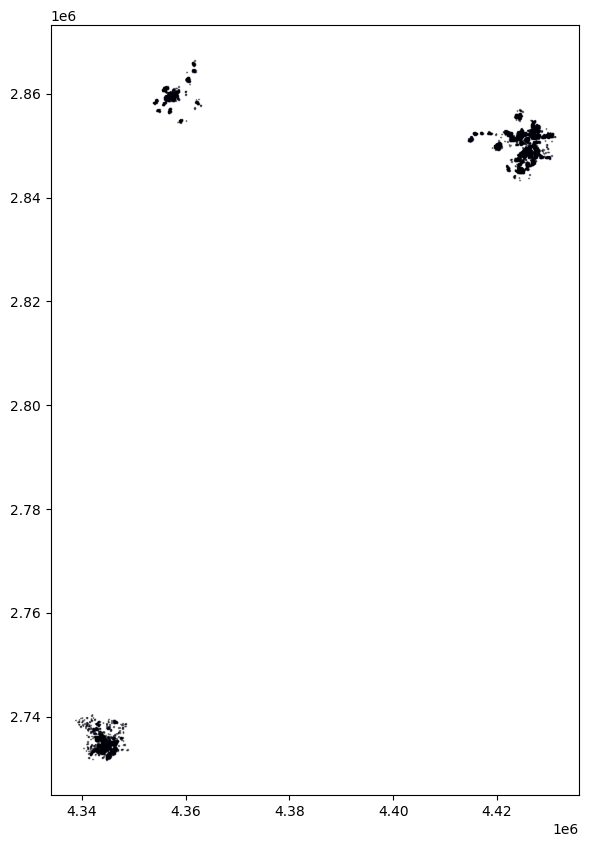

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
alle_staedte_cluster.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
cold_spots_merged.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
plt.show()

In [ ]:
print(alle_staedte_cluster.total_bounds)
print(cold_spots_merged.total_bounds)

[4338600. 2731600. 4431200. 2866500.]
[inf inf inf inf]


Fehler: Projektion o.ä der Daten stimmt nicht überein. Daten auf gleiches CRS setzen probiert, liefert aber auch keine Ergebnisse ...

# Verknüpfung mit in QGIS erstellten Dateien

In [4]:
# Definiere eine Liste mit den Dateinamen der Shapefiles
shapefiles = [
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_30min_erreichb.shp"

]

# Schleife durch die Shapefiles
for shapefile in shapefiles:
    # Shapefile laden
    gdf = gpd.read_file(shapefile)

    # CRS setzen, falls es fehlt oder falsch ist
    if gdf.crs is None:
        gdf.crs = 'epsg:4326'  # Ersetze dies durch das tatsächliche CRS des Shapefiles, falls bekannt
    #Falls CRS nicht EPSG:4326 ist, wird es in EPSG:4326 umgewandelt bevor es in EPSG:32632 umgewandelt wird
    elif gdf.crs != 'epsg:4326':
        gdf = gdf.to_crs('epsg:4326')

    # Geometrie in UTM Zone 32N umwandeln
    gdf = gdf.to_crs(epsg=32632)  # UTM Zone 32N

    # Fläche berechnen und ausgeben
    flaeche = gdf.geometry.area.sum()
    print(f"Fläche von {shapefile}: {flaeche:.2f} Quadratmeter")

Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp: 4277014.12 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp: 10409160.22 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp: 18731271.43 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp: 28873504.75 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_25min_erreichb.shp: 39144728.99 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_30min_erreichb.shp: 48266845.77 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_5min_erreichb.shp: 3928349.53 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp: 7673340.41 Quadratmeter
Fläche von /content/drive/MyDrive/D

Berechnungen Erreichbarkeit:
1. a) wieviel % des Stadtgebiets sind innerhalb von x Minuten erreichbar und

b) wieviel % der unterschiedlichen Bevölkerungsgruppen haben Zugang innerhalb von x Minuten

In [5]:
# 1a)
# Stadtflächen in Quadratmetern (bereits in CORINE Notebook berechnet)
total_area_noerdlingen = 68424223.57
total_area_kempten = 63213005.57
total_area_ingolstadt = 133458846.44


# Definiere eine Liste mit den Dateinamen der Shapefiles
shapefiles = [
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_30min_erreichb.shp"

]

# Definiere ein Dictionary, um die Stadtnamen den Gesamtflächen zuzuordnen
stadt_mapping = {
    "noerdlingen": total_area_noerdlingen,
    "kempten": total_area_kempten,
    "ingolstadt": total_area_ingolstadt,
}

# Schleife durch die Shapefiles
for shapefile in shapefiles:
    # Stadtname und Minuten aus dem Dateinamen extrahieren
    stadtname = shapefile.split("/")[-1].split("_")[0]  # Beispiel: "noerdlingen"
    minuten = shapefile.split("/")[-1].split("_")[1].split("min")[0]  # Beispiel: "5"

    # Shapefile laden
    gdf = gpd.read_file(shapefile)

    # Reproject to UTM Zone 32N before calculating area
    gdf = gdf.to_crs(epsg=32632)

    # Fläche berechnen
    flaeche = gdf.geometry.area.sum()

    # Prozentualen Anteil berechnen
    prozentualer_anteil = (flaeche / stadt_mapping[stadtname.lower()]) * 100

    # Name für das Shapefile erstellen
    shapefile_name = f"{stadtname.capitalize()}_{minuten}min"

    # Ergebnis ausgeben und Shapefile-Namen anzeigen
    print(f"Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in {shapefile_name}: {prozentualer_anteil:.2f}%")

Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_5min: 6.25%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_10min: 15.21%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_15min: 27.38%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_20min: 42.20%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_25min: 57.21%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Noerdlingen_30min: 70.54%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Kempten_5min: 6.21%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Kempten_10min: 12.14%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Kempten_15min: 18.66%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Kempten_20min: 26.11%
Prozentualer Anteil der erreichbaren Fläche an Gesamtfläche in Kempten_25min: 33.54%
Prozentualer Anteil der erreichbaren Fläche a

b) wieviel % der unterschiedlichen Bevölkerungsgruppen haben Zugang zu cold spot innerhalb von x Minuten

In [6]:
# Clusterdaten
alle_staedte_cluster_Gitterzellen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster_Gitterzellen.geojson")

print(alle_staedte_cluster_Gitterzellen.crs)

EPSG:3035


In [7]:
# Geodataframe aus shapefiles mit Erreichbarkeiten erstellen

# Definiere eine Liste mit den Dateinamen der Shapefiles
shapefiles = [
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_30min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_25min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_30min_erreichb.shp"

]
# Definiere ein Dictionary, um die Stadtnamen den Shapefiles zuzuordnen
stadt_mapping = {
    "noerdlingen": ["/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_" + str(i) + "min_erreichb.shp" for i in [5, 10, 15, 20, 25, 30]],
    "kempten": ["/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_" + str(i) + "min_erreichb.shp" for i in [5, 10, 15, 20, 25, 30]],
    "ingolstadt": ["/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_" + str(i) + "min_erreichb.shp" for i in [5, 10, 15, 20, 25, 30]]
}


# Erstelle einen leeren DataFrame
data = []

# Schleife durch die Städte
for stadt, shapefile_list in stadt_mapping.items():
    stadt_data = {"Stadt": stadt}
    # Schleife durch die Shapefiles der Stadt
    for shapefile in shapefile_list:
        # Extrahiere die Minuten aus dem Dateinamen
        minuten = int(shapefile.split("_")[1].split("min")[0])

        # Lade das Shapefile und projiziere es
        gdf = gpd.read_file(shapefile).to_crs(epsg=32632)

        # Füge die Geometrie dem Dictionary hinzu
        stadt_data[f"geometry_{minuten}min"] = gdf.geometry.union_all()

    # Füge die Daten der Stadt dem DataFrame hinzu
    data.append(stadt_data)


# Erstelle den GeoDataFrame mit CRS
erreichbarkeit_gdf = gpd.GeoDataFrame(data, geometry="geometry_5min", crs="epsg:32632")

# Setze die Geometriespalten und konvertiere sie in GeoSeries
for minuten in range(5, 35, 5): # iteriert in 5er schritten über die Zeitlimits 5 bis 35(exklusive)
    erreichbarkeit_gdf[f"geometry_{minuten}min"] = gpd.GeoSeries(erreichbarkeit_gdf[f"geometry_{minuten}min"], crs="epsg:32632") # Hier GeoSeries verwenden

# Gib den GeoDataFrame aus
print(erreichbarkeit_gdf)
print(erreichbarkeit_gdf.crs)

         Stadt                                      geometry_5min  \
0  noerdlingen  MULTIPOLYGON (((610659.042 5405870.887, 610444...   
1      kempten  MULTIPOLYGON (((598086.059 5283873.242, 598376...   
2   ingolstadt  MULTIPOLYGON (((674300.517 5397743.637, 674246...   

                                      geometry_10min  \
0  MULTIPOLYGON (((610078.811 5407323.158, 609432...   
1  MULTIPOLYGON (((598183.2 5284279.883, 598470.9...   
2  MULTIPOLYGON (((674246.02 5397771.915, 674212....   

                                      geometry_15min  \
0  MULTIPOLYGON (((610380.665 5405858.948, 609919...   
1  MULTIPOLYGON (((598322.817 5283401.895, 598298...   
2  MULTIPOLYGON (((674246.02 5397771.915, 674212....   

                                      geometry_20min  \
0  MULTIPOLYGON (((609033.735 5407962.056, 609031...   
1  MULTIPOLYGON (((598298.551 5283390.924, 598259...   
2  MULTIPOLYGON (((674379.519 5397709.469, 674367...   

                                      geometry_2

In [8]:
# Daten Cluster und Cold-Spot-Erreichbarkeiten zusammenführen für weitere Analysen

# Cluster CRS auf Erreichbarkeiten CRS umstellen
alle_staedte_cluster_Gitterzellen = alle_staedte_cluster_Gitterzellen.to_crs(erreichbarkeit_gdf.crs)
print(alle_staedte_cluster_Gitterzellen.crs)

epsg:32632


In [9]:
# Annahme: alle_staedte_cluster_Gitterzellen und erreichbarkeit_gdf sind bereits geladen und im gleichen CRS

# Leere Liste zum Speichern der Intersection-Geometrien und zugehöriger Daten
intersection_data = []

# Iteration über alle Gitterzellen
for index, row in alle_staedte_cluster_Gitterzellen.iterrows():
    alle_staedte_cluster_Gitterzellen_geometry = row.geometry  # Geometrie der aktuellen Gitterzelle
    # Iteration über alle Erreichbarkeitszonen
    for index2, row2 in erreichbarkeit_gdf.iterrows():
        # Intersection für alle Zeitfenster berechnen
        intersection_geometries = {
            'intersection_geometry_5min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_5min),
            'intersection_geometry_10min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_10min),
            'intersection_geometry_15min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_15min),
            'intersection_geometry_20min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_20min),
            'intersection_geometry_25min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_25min),
            'intersection_geometry_30min': alle_staedte_cluster_Gitterzellen_geometry.intersection(row2.geometry_30min)
        }

        # Wenn mindestens eine Intersection nicht leer ist, Daten speichern
        if any(not geom.is_empty for geom in intersection_geometries.values()):
            # Daten aus beiden GeoDataFrames zusammenführen
            data = {**row.to_dict(), **row2.to_dict(), **intersection_geometries}

            intersection_data.append(data)

# GeoDataFrame aus den gesammelten Daten erstellen
intersection_all_timezones_gdf = gpd.GeoDataFrame(intersection_data, geometry='intersection_geometry_5min', crs=alle_staedte_cluster_Gitterzellen.crs)

# GeoDataFrame ausgeben
print(intersection_all_timezones_gdf.columns)

Index(['GITTER_ID_100m', 'x_mp_100m', 'y_mp_100m', 'AnteilUeber65',
       'AnteilAuslaender', 'durchschnFlaechejeBew', 'Durchschnittsalter',
       'Einwohner', 'durchschnMieteQM', 'Anteil_unter10', 'cluster',
       'geometry', 'Stadt', 'geometry_5min', 'geometry_10min',
       'geometry_15min', 'geometry_20min', 'geometry_25min', 'geometry_30min',
       'intersection_geometry_5min', 'intersection_geometry_10min',
       'intersection_geometry_15min', 'intersection_geometry_20min',
       'intersection_geometry_25min', 'intersection_geometry_30min'],
      dtype='object')


**intersection_all_timezones_gdf** beinhaltet alle Überschneidungen zwischen Cold Spots und Gitterzellen

==> intersection_geometry_xmin enthalten jetzt Überlappungsflächen zwischen


Gitterzellen und jeweiligen Erreichbarkeitszonen (Clusterspalte erscheint leer, ist aber enthalten, wird nur wegen Größe nicht richtig angezeigt)

In [ ]:
intersection_all_timezones_gdf.to_file("intersection_all_timezones_gdf.geojson", driver="GeoJSON")

Spalte intersection_geometry_5min geht komischerweise bei Export immer verloren... evtl Versuch mit anderer Exportmethode, zb: Pickle

In [ ]:
# intersection file aus drive laden
#intersection_all_timezones_gdf = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Erreichbarkeiten/intersection_all_timezones_gdf.geojson")

In [10]:
print(intersection_all_timezones_gdf.crs) # hier wird erstmal mit lokal erstelltem gdf weitergearbeitet (enthält alle Spalten)

epsg:32632


In [11]:
print(intersection_all_timezones_gdf.columns)

Index(['GITTER_ID_100m', 'x_mp_100m', 'y_mp_100m', 'AnteilUeber65',
       'AnteilAuslaender', 'durchschnFlaechejeBew', 'Durchschnittsalter',
       'Einwohner', 'durchschnMieteQM', 'Anteil_unter10', 'cluster',
       'geometry', 'Stadt', 'geometry_5min', 'geometry_10min',
       'geometry_15min', 'geometry_20min', 'geometry_25min', 'geometry_30min',
       'intersection_geometry_5min', 'intersection_geometry_10min',
       'intersection_geometry_15min', 'intersection_geometry_20min',
       'intersection_geometry_25min', 'intersection_geometry_30min'],
      dtype='object')


wieviele % aller Einwohner*innen haben Zugang innerhalb von x Minuten?

In [12]:
Noerdlingen_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/NOERDLINGEN_neu_merged.csv")
Kempten_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/KEMPTEN_neu_merged_2.csv")
Ingolstadt_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/INGOLSTADT_neu_merged_2.csv")

In [34]:
print(Noerdlingen_df.head())

                   GITTER_ID_100m  x_mp_100m  y_mp_100m  \
0  CRS3035RES100mN2854400E4359000    4359050    2854450   
1  CRS3035RES100mN2854500E4358400    4358450    2854550   
2  CRS3035RES100mN2854500E4358700    4358750    2854550   
3  CRS3035RES100mN2854500E4358800    4358850    2854550   
4  CRS3035RES100mN2854500E4358900    4358950    2854550   

                  geometry  AnteilUeber65  AnteilAuslaender  \
0  POINT (4359050 2854450)            NaN               NaN   
1  POINT (4358450 2854550)            NaN               NaN   
2  POINT (4358750 2854550)            NaN               NaN   
3  POINT (4358850 2854550)          13.64               NaN   
4  POINT (4358950 2854550)            NaN               NaN   

   durchschnFlaechejeBew  Durchschnittsalter  Einwohner  durchschnMieteQM  \
0                  65.00               37.13          3               NaN   
1                    NaN               53.48          3               NaN   
2                  39.04           

Spalten mit absoluten Werten der Attribute ü65, u10 und mit Migrationshintergrund erstellen, um Gesamtsummen der Bevölkerungsgruppen zu berechnen

In [35]:
# Annahme: Noerdlingen_df, Kempten_df, Ingolstadt_df sind bereits geladen

def calculate_total_population_groups(stadt_df):
    """
    Berechnet die Gesamtsummen für Ü65, U10 und mit Migrationshintergrund.

    Args:
        stadt_df: DataFrame für eine Stadt (z.B. Noerdlingen_df).

    Returns:
        Dictionary mit den Gesamtsummen für die Bevölkerungsgruppen.
    """

    # Berechne die absoluten Werte für Ü65 und mit Migrationshintergrund
    stadt_df["Ueber65_absolut"] = (stadt_df["Einwohner"] * stadt_df["AnteilUeber65"]) / 100
    stadt_df["Auslaender_absolut"] = (stadt_df["Einwohner"] * stadt_df["AnteilAuslaender"]) / 100

    # Berechne die Gesamtsummen
    total_ueber65 = stadt_df["Ueber65_absolut"].sum()
    total_unter10 = stadt_df["Unter10"].sum()
    total_auslaender = stadt_df["Auslaender_absolut"].sum()

    # Gib die Gesamtsummen als Dictionary zurück
    return {
        "Ueber65": total_ueber65,
        "Unter10": total_unter10,
        "Auslaender": total_auslaender,
    }

# Berechne die Gesamtsummen für jede Stadt
total_population_groups_Noerdlingen = calculate_total_population_groups(Noerdlingen_df)
total_population_groups_Kempten = calculate_total_population_groups(Kempten_df)
total_population_groups_Ingolstadt = calculate_total_population_groups(Ingolstadt_df)

# Gib die Ergebnisse aus
print("Noerdlingen:", total_population_groups_Noerdlingen)
print("Kempten:", total_population_groups_Kempten)
print("Ingolstadt:", total_population_groups_Ingolstadt)

Noerdlingen: {'Ueber65': np.float64(4402.828299999999), 'Unter10': np.int64(1693), 'Auslaender': np.float64(2719.1029000000003)}
Kempten: {'Ueber65': np.float64(14480.1746), 'Unter10': np.int64(5977), 'Auslaender': np.float64(10763.844700000001)}
Ingolstadt: {'Ueber65': np.float64(24904.8688), 'Unter10': np.int64(14012), 'Auslaender': np.float64(27780.507700000002)}


In [13]:
# Gesamt-EWZ anhand der ursprünglichen Dataframes für die Stadt berechnen
Noerdlingen_df['Einwohner']= pd.to_numeric(Noerdlingen_df['Einwohner'])
Kempten_df['Einwohner']= pd.to_numeric(Kempten_df['Einwohner'])
Ingolstadt_df['Einwohner']= pd.to_numeric(Ingolstadt_df['Einwohner'])

In [14]:
# Gesamt-Einwohner in Stadt
total_population_noe = Noerdlingen_df['Einwohner'].sum()
total_population_kemp = Kempten_df['Einwohner'].sum()
total_population_ing = Ingolstadt_df['Einwohner'].sum()

print(total_population_noe)
print(total_population_kemp)
print(total_population_ing)

20189
65017
136447


In [15]:
# wieiviele Einwohner leben innerhalb der x-minütigen Erreichbarkeitszonen in der jeweiligen Stadt

# Erstelle ein leeres Dictionary, um die Ergebnisse zu speichern
results = {}

# Schleife über alle Städte
for stadt in ["Noerdlingen", "Kempten", "Ingolstadt"]:
    results[stadt] = {}  # Initialisiere ein leeres Dictionary für jede Stadt

    # Schleife über alle Zeitfenster (5min, 10min, 15min, 20min, 25min, 30min)
    for minuten in [5, 10, 15, 20, 25, 30]:
        # Spaltenname für die Geometrie und Einwohner
        geometry_col = f"intersection_geometry_{minuten}min"
        einwohner_col = "Einwohner"

        # Filtere die Daten nach Stadt und Geometrie
        filtered_data = [
            d for d in intersection_data
            if not d[geometry_col].is_empty
            and d.get('Stadt', '').lower() == stadt.lower()  # Case-insensitive comparison
        ]

        # Berechne die Summe der Einwohner für das aktuelle Zeitfenster und die Stadt
        total_einwohner = sum(
            int(d[einwohner_col]) if isinstance(d[einwohner_col], str) and d[einwohner_col].isdigit() else d[einwohner_col]
            for d in filtered_data
        )

        # Speichere das Ergebnis im Dictionary
        results[stadt][f"{minuten}min"] = total_einwohner

# Gib die Ergebnisse aus
for stadt, stadt_results in results.items():
    print(f"Ergebnisse für {stadt}:")
    for minuten, total_einwohner in stadt_results.items():
        print(f"  Summe der Einwohner innerhalb der {minuten} Erreichbarkeitszone: {total_einwohner}")
    print("-" * 20)

Ergebnisse für Noerdlingen:
  Summe der Einwohner innerhalb der 5min Erreichbarkeitszone: 421
  Summe der Einwohner innerhalb der 10min Erreichbarkeitszone: 1276
  Summe der Einwohner innerhalb der 15min Erreichbarkeitszone: 2875
  Summe der Einwohner innerhalb der 20min Erreichbarkeitszone: 5618
  Summe der Einwohner innerhalb der 25min Erreichbarkeitszone: 8608
  Summe der Einwohner innerhalb der 30min Erreichbarkeitszone: 14223
--------------------
Ergebnisse für Kempten:
  Summe der Einwohner innerhalb der 5min Erreichbarkeitszone: 4620
  Summe der Einwohner innerhalb der 10min Erreichbarkeitszone: 7618
  Summe der Einwohner innerhalb der 15min Erreichbarkeitszone: 12888
  Summe der Einwohner innerhalb der 20min Erreichbarkeitszone: 19619
  Summe der Einwohner innerhalb der 25min Erreichbarkeitszone: 27846
  Summe der Einwohner innerhalb der 30min Erreichbarkeitszone: 34420
--------------------
Ergebnisse für Ingolstadt:
  Summe der Einwohner innerhalb der 5min Erreichbarkeitszone:

In [16]:
# prozentuale Einwohnerzahl innerhalb x-minütiger Zeitzone

# Annahme: results Dictionary aus vorherigem Code,
# total_population_noe, total_population_kemp, total_population_ing sind definiert

# Definiere ein Dictionary, um die Gesamtbevölkerung jeder Stadt zu speichern
total_population = {
    "Noerdlingen": total_population_noe,
    "Kempten": total_population_kemp,
    "Ingolstadt": total_population_ing,
}

# Definiere ein Dictionary, um die prozentualen Ergebnisse zu speichern
percentage_Einwohner_dict = {}

# Gib die prozentualen Ergebnisse aus und speichere sie im Dictionary
for stadt, stadt_results in results.items():
    percentage_Einwohner_dict[stadt] = {}  # Initialisiere ein Dictionary für die aktuelle Stadt
    print(f"Prozentuale Ergebnisse für {stadt}:")
    for minuten, total_einwohner in stadt_results.items():
        # Berechne den Prozentsatz
        prozent = (total_einwohner / total_population[stadt]) * 100

        # Speichere den Prozentsatz im Dictionary
        percentage_Einwohner_dict[stadt][minuten] = prozent

        print(f"  {minuten} Erreichbarkeitszone: {prozent:.2f}% der Einwohner")
    print("-" * 20)

# Gib das percentage_dict aus (optional)
print("percentage_dict:", percentage_Einwohner_dict)

Prozentuale Ergebnisse für Noerdlingen:
  5min Erreichbarkeitszone: 2.09% der Einwohner
  10min Erreichbarkeitszone: 6.32% der Einwohner
  15min Erreichbarkeitszone: 14.24% der Einwohner
  20min Erreichbarkeitszone: 27.83% der Einwohner
  25min Erreichbarkeitszone: 42.64% der Einwohner
  30min Erreichbarkeitszone: 70.45% der Einwohner
--------------------
Prozentuale Ergebnisse für Kempten:
  5min Erreichbarkeitszone: 7.11% der Einwohner
  10min Erreichbarkeitszone: 11.72% der Einwohner
  15min Erreichbarkeitszone: 19.82% der Einwohner
  20min Erreichbarkeitszone: 30.18% der Einwohner
  25min Erreichbarkeitszone: 42.83% der Einwohner
  30min Erreichbarkeitszone: 52.94% der Einwohner
--------------------
Prozentuale Ergebnisse für Ingolstadt:
  5min Erreichbarkeitszone: 2.13% der Einwohner
  10min Erreichbarkeitszone: 7.81% der Einwohner
  15min Erreichbarkeitszone: 18.10% der Einwohner
  20min Erreichbarkeitszone: 28.23% der Einwohner
  25min Erreichbarkeitszone: 38.43% der Einwohner
 

**gleiches mit Menschen ü65, u10 und Menschen mit Migrationshintergrund**

In [17]:
# weitere Attribute: ü65, u10, Menschen mit Migrationshintergrund
# zunächst: absolute Zahlen berechnen und gdf anhängen

# Replace empty strings with NaN and then convert to float
intersection_all_timezones_gdf["Einwohner"] = pd.to_numeric(intersection_all_timezones_gdf["Einwohner"].replace('', np.nan))
intersection_all_timezones_gdf["AnteilUeber65"] = pd.to_numeric(intersection_all_timezones_gdf["AnteilUeber65"].replace('', np.nan))
intersection_all_timezones_gdf["Anteil_unter10"] = pd.to_numeric(intersection_all_timezones_gdf["Anteil_unter10"].replace('', np.nan))
intersection_all_timezones_gdf["AnteilAuslaender"] = pd.to_numeric(intersection_all_timezones_gdf["AnteilAuslaender"].replace('', np.nan))

# Now perform the calculations, filling NaN with 0 before converting to int
# Divide the percentage columns by 100 to get the actual proportions
intersection_all_timezones_gdf["abs_ueber65"] = (intersection_all_timezones_gdf["Einwohner"] * (intersection_all_timezones_gdf["AnteilUeber65"] / 100)).fillna(0).astype(int)
intersection_all_timezones_gdf["abs_unter10"] = (intersection_all_timezones_gdf["Einwohner"] * (intersection_all_timezones_gdf["Anteil_unter10"] / 100)).fillna(0).astype(int)
intersection_all_timezones_gdf["abs_auslaender"] = (intersection_all_timezones_gdf["Einwohner"] * (intersection_all_timezones_gdf["AnteilAuslaender"] / 100)).fillna(0).astype(int)
# Gib den aktualisierten GeoDataFrame aus (optional)
print(intersection_all_timezones_gdf.head(5))

                   GITTER_ID_100m  x_mp_100m  y_mp_100m  AnteilUeber65  \
0  CRS3035RES100mN2854400E4359000    4359050    2854450            NaN   
1  CRS3035RES100mN2854500E4358400    4358450    2854550            NaN   
2  CRS3035RES100mN2854500E4358700    4358750    2854550            NaN   
3  CRS3035RES100mN2854500E4358800    4358850    2854550          13.64   
4  CRS3035RES100mN2854500E4358900    4358950    2854550            NaN   

   AnteilAuslaender durchschnFlaechejeBew Durchschnittsalter  Einwohner  \
0               NaN                  65.0              37.13          3   
1               NaN                                    53.48          3   
2               NaN                 39.04              57.78          6   
3               NaN                 78.77              43.04         22   
4               NaN                 48.23              36.65         20   

  durchschnMieteQM  Anteil_unter10  ...  \
0                         0.000000  ...   
1                 

3 neue Spalten enthalten absolute Werte für 3 Attribute ü65, u10 und M.m.MH

Gesamt-Summen der Bevölkerungsgruppen innerhalb Stadt berechen (Summe ü65, u10 und Menschen m Migr.)

In [18]:
# Definiere die Städte und die zu summierenden Spalten
cities = ["Noerdlingen", "Kempten", "Ingolstadt"]
attributes = ["abs_ueber65", "abs_unter10", "abs_auslaender"]

# Erstelle ein Dictionary, um die Summen zu speichern
city_attribute_sums = {}

# Schleife über die Städte
for city in cities:
    city_attribute_sums[city] = {}  # Initialisiere ein Dictionary für die aktuelle Stadt

    # Filtere den DataFrame nach der aktuellen Stadt
    city_data = intersection_all_timezones_gdf[intersection_all_timezones_gdf["Stadt"].str.lower() == city.lower()]

    # Schleife über die Attribute
    for attribute in attributes:
        # Berechne die Summe des Attributs für die aktuelle Stadt
        total_sum = city_data[attribute].sum()

        # Speichere die Summe im Dictionary
        city_attribute_sums[city][attribute] = total_sum

# Gib das Dictionary mit den Summen aus
print(city_attribute_sums)

{'Noerdlingen': {'abs_ueber65': np.int64(2890), 'abs_unter10': np.int64(1211), 'abs_auslaender': np.int64(1593)}, 'Kempten': {'abs_ueber65': np.int64(7857), 'abs_unter10': np.int64(2835), 'abs_auslaender': np.int64(5153)}, 'Ingolstadt': {'abs_ueber65': np.int64(10991), 'abs_unter10': np.int64(6240), 'abs_auslaender': np.int64(12341)}}


für alle Zeilen der Spalten intersection_geometry_xmin, die nicht leere Polygone enthalten != POLYGON EMPTY, (im intersection_all_timezones gdf) die entsprechenden Zeilen der Spalten abs_ueber65, abs_unter10 sowie abs_auslaender finden, dann die absoluten Zahlen der 3 Variablen für jede intersection_geometry_xmin addieren, sodass Summen der ü65, u10 Jährigen und Menschen mit Migrationhintergrund, welche in x Minuten erreichbar sind, herauskommen

In [19]:
# Annahme: intersection_all_timezones ist bereits als GeoDataFrame geladen

# Definiere die Zeitfenster in Minuten
time_windows = [5, 10, 15, 20, 25, 30]

# Liste der Attribute
attributes = ["abs_ueber65", "abs_unter10", "abs_auslaender"]

# Schleife über die Zeitfenster
for time_window in time_windows:
    # Erstelle ein leeres Dictionary, um die Summen für das aktuelle Zeitfenster zu speichern
    sum_dict = {}

    # Schleife über die Zeilen im GeoDataFrame
    for index, row in intersection_all_timezones_gdf.iterrows():
        # Geometriespalte für das aktuelle Zeitfenster
        geometry_col = f"intersection_geometry_{time_window}min"

        # Wenn die Geometrie nicht leer ist, berechne die Summe der Attribute
        if not row[geometry_col].is_empty:  # Überprüfen, ob die Geometrie nicht leer ist
            # Berechne die Summe der Attribute für die aktuelle Zeile
            sum_values = {
                attribute: row.get(attribute, 0)  # Hole den Wert des Attributs, falls vorhanden, sonst 0
                for attribute in attributes
            }

            # Füge die Summen zum Dictionary für das aktuelle Zeitfenster hinzu
            sum_dict[index] = sum_values
        else:
            # Wenn die Geometrie leer ist, setze die Summen auf 0
            sum_dict[index] = {attribute: 0 for attribute in attributes}

    # Füge die berechneten Summen als neue Spalten zum GeoDataFrame hinzu,
    # wobei der Spaltenname das aktuelle Zeitfenster enthält
    for attribute in attributes:
        intersection_all_timezones_gdf[f"sum_{attribute}_{time_window}min"] = intersection_all_timezones_gdf.index.map(
            lambda x: sum_dict.get(x, {}).get(attribute, 0)
        )

# Gebe den aktualisierten GeoDataFrame aus
print(intersection_all_timezones_gdf[[f"sum_{attribute}_{time_window}min" for attribute in attributes for time_window in time_windows]])

      sum_abs_ueber65_5min  sum_abs_ueber65_10min  sum_abs_ueber65_15min  \
0                        0                      0                      0   
1                        0                      0                      0   
2                        0                      0                      0   
3                        0                      0                      0   
4                        0                      0                      0   
...                    ...                    ...                    ...   
2952                     0                      0                      0   
2953                     0                      0                      0   
2954                     0                      0                      0   
2955                     0                      0                      0   
2956                     0                      0                      0   

      sum_abs_ueber65_20min  sum_abs_ueber65_25min  sum_abs_ueber65_30min  \
0         

überprüfen, ob es Werte in jeder Spalte gibt und wieviele

In [20]:
# Annahme: intersection_all_timezones ist bereits als GeoDataFrame geladen

# Definiere die Zeitfenster in Minuten
time_windows = [5, 10, 15, 20, 25, 30]

# Liste der Attribute
attributes = ["abs_ueber65", "abs_unter10", "abs_auslaender"]

# Dictionary, um die Anzahl der Nicht-Null-Werte für jede Spalte zu speichern
non_zero_counts = {}

# Schleife über die Attribute und Zeitfenster, um die Spaltennamen zu erstellen
for attribute in attributes:
    for time_window in time_windows:
        column_name = f"sum_{attribute}_{time_window}min"

        # Zähle die Nicht-Null-Werte in der aktuellen Spalte
        non_zero_count = intersection_all_timezones_gdf[column_name][intersection_all_timezones_gdf[column_name] != 0].count()

        # Speichere die Anzahl im Dictionary
        non_zero_counts[column_name] = non_zero_count

# Gib die Anzahl der Nicht-Null-Werte für jede Spalte aus
for column_name, count in non_zero_counts.items():
    print(f"Anzahl der Nicht-Null-Werte in der Spalte '{column_name}': {count}")

Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_5min': 165
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_10min': 422
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_15min': 819
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_20min': 1265
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_25min': 1729
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_ueber65_30min': 2190
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_5min': 132
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_10min': 303
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_15min': 607
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_20min': 950
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_25min': 1310
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_unter10_30min': 1672
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_auslaender_5min': 104
Anzahl der Nicht-Null-Werte in der Spalte 'sum_abs_auslaender_10min': 24

absolute Summe der Menschen je Stadt in x Erreichbarkeitszone

In [21]:
# Annahme: intersection_all_timezones ist bereits als GeoDataFrame geladen

# Definiere die Zeitfenster in Minuten
time_windows = [5, 10, 15, 20, 25, 30]

# Liste der Attribute
attributes = ["abs_ueber65", "abs_unter10", "abs_auslaender"]

# Liste der Städte
cities = ["Noerdlingen", "Kempten", "Ingolstadt"]

# Dictionary, um die Summen für jede Stadt und jedes Attribut zu speichern
city_attribute_sums_per_timezone = {}

# Schleife über die Städte
for city in cities:
    city_attribute_sums[city] = {}  # Initialisiere ein Dictionary für die aktuelle Stadt

    # Filtere den GeoDataFrame nach der aktuellen Stadt (verbesserte Filterung)
    city_data = intersection_all_timezones_gdf[
        intersection_all_timezones_gdf['Stadt'].str.lower() == city.lower()  # Groß-/Kleinschreibung ignorieren
    ]

    # Schleife über die Attribute
    for attribute in attributes:
        city_attribute_sums[city][attribute] = {}  # Initialisiere ein Dictionary für das aktuelle Attribut

        # Schleife über die Zeitfenster
        for time_window in time_windows:
            # Spaltenname für die aktuelle Summe
            column_name = f"sum_{attribute}_{time_window}min"

            # Berechne die Summe der Zellwerte für die aktuelle Stadt, das Attribut und das Zeitfenster
            total_sum = city_data[column_name].sum()

            # Speichere die Summe im Dictionary
            city_attribute_sums[city][attribute][time_window] = total_sum

# Gib die Summen in der gewünschten Form aus
attribute_labels = {
    "abs_ueber65": "Menschen über 65",
    "abs_unter10": "Kinder unter 10",
    "abs_auslaender": "Menschen mit Migrationshintergrund",
}

for city, attribute_sums in city_attribute_sums.items():
    for attribute, time_sums in attribute_sums.items():
        for time_window, total_sum in time_sums.items():
            print(f"Summe der {attribute_labels[attribute]} in {city}, die {time_window} Minuten vom nächsten Cold Spot entfernt leben: {total_sum}")

Summe der Menschen über 65 in Noerdlingen, die 5 Minuten vom nächsten Cold Spot entfernt leben: 24
Summe der Menschen über 65 in Noerdlingen, die 10 Minuten vom nächsten Cold Spot entfernt leben: 196
Summe der Menschen über 65 in Noerdlingen, die 15 Minuten vom nächsten Cold Spot entfernt leben: 501
Summe der Menschen über 65 in Noerdlingen, die 20 Minuten vom nächsten Cold Spot entfernt leben: 1177
Summe der Menschen über 65 in Noerdlingen, die 25 Minuten vom nächsten Cold Spot entfernt leben: 1820
Summe der Menschen über 65 in Noerdlingen, die 30 Minuten vom nächsten Cold Spot entfernt leben: 2890
Summe der Kinder unter 10 in Noerdlingen, die 5 Minuten vom nächsten Cold Spot entfernt leben: 67
Summe der Kinder unter 10 in Noerdlingen, die 10 Minuten vom nächsten Cold Spot entfernt leben: 133
Summe der Kinder unter 10 in Noerdlingen, die 15 Minuten vom nächsten Cold Spot entfernt leben: 294
Summe der Kinder unter 10 in Noerdlingen, die 20 Minuten vom nächsten Cold Spot entfernt leben:

(prozentualer Anteil der Attribute **innerhalb Zeitzone an Gesamt-EWZ**)

In [22]:
# Annahme: intersection_all_timezones und city_attribute_sums sind bereits geladen

# Definiere die Zeitfenster in Minuten
time_windows = [5, 10, 15, 20, 25, 30]

# Liste der Attribute
attributes = ["abs_ueber65", "abs_unter10", "abs_auslaender"]

# Liste der Städte
cities = ["Noerdlingen", "Kempten", "Ingolstadt"]

# Dictionary, um die prozentualen Anteile zu speichern
city_attribute_percentages = {}

# Definiere ein Dictionary, um die Gesamtbevölkerung jeder Stadt zu speichern
total_population = {
    "Noerdlingen": total_population_noe,
    "Kempten": total_population_kemp,
    "Ingolstadt": total_population_ing,
}
# Schleife über die Städte
for city in cities:
    city_attribute_percentages[city] = {}  # Initialisiere ein Dictionary für die aktuelle Stadt

    # Gesamteinwohnerzahl der aktuellen Stadt (aus dem Dictionary)
    total_population_city = total_population[city]

    # Gib die Gesamteinwohnerzahl für die aktuelle Stadt aus
    print(f"Gesamteinwohnerzahl in {city}: {total_population_city}")

    # Schleife über die Attribute
    for attribute in attributes:
        city_attribute_percentages[city][attribute] = {}  # Initialisiere ein Dictionary für das aktuelle Attribut

        # Schleife über die Zeitfenster
        for time_window in time_windows:
            # Summe der Menschen für die aktuelle Stadt, das Attribut und das Zeitfenster
            total_sum = city_attribute_sums[city][attribute][time_window]

            # Berechne den prozentualen Anteil
            if total_population_city > 0:  # Vermeide Division durch Null
                percentage = (total_sum / total_population_city) * 100
            else:
                percentage = 0

            # Speichere den prozentualen Anteil im Dictionary
            city_attribute_percentages[city][attribute][time_window] = percentage

# Gib die prozentualen Anteile in der gewünschten Form aus
attribute_labels = {
    "abs_ueber65": "Menschen über 65",
    "abs_unter10": "Kinder unter 10",
    "abs_auslaender": "Menschen mit Migrationshintergrund",
}

for city, attribute_percentages in city_attribute_percentages.items():
    for attribute, time_percentages in attribute_percentages.items():
        for time_window, percentage in time_percentages.items():
            print(f"Prozentualer Anteil der {attribute_labels[attribute]} in {city}, die innerhalb von {time_window} Minuten einen Cold Spot erreichen: {percentage:.2f}%")

Gesamteinwohnerzahl in Noerdlingen: 20189
Gesamteinwohnerzahl in Kempten: 65017
Gesamteinwohnerzahl in Ingolstadt: 136447
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 5 Minuten einen Cold Spot erreichen: 0.12%
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 10 Minuten einen Cold Spot erreichen: 0.97%
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 15 Minuten einen Cold Spot erreichen: 2.48%
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 20 Minuten einen Cold Spot erreichen: 5.83%
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 25 Minuten einen Cold Spot erreichen: 9.01%
Prozentualer Anteil der Menschen über 65 in Noerdlingen, die innerhalb von 30 Minuten einen Cold Spot erreichen: 14.31%
Prozentualer Anteil der Kinder unter 10 in Noerdlingen, die innerhalb von 5 Minuten einen Cold Spot erreichen: 0.33%
Prozentualer Anteil der Kinder unter 10 in Noer

prozentualer Anteil von Attribut **innerhalb Zeitzone, an Gesamtsumme des Attributs**

In [36]:
# Excel Tabelle mit Summe der Bewohner innerhalb Erreichbarkeitszone für alle Bewohner sowie Gruppen

alle_erreichbarkeiten_tabelle = "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Erreichbarkeiten/Erreichbarkeiten innerhalb Gruppen .xlsx"

alle_erreichbarkeiten_df = pd.read_excel(alle_erreichbarkeiten_tabelle)
print(alle_erreichbarkeiten_df)

          Stadt                            Attribut  5 Minuten  10 Minuten  \
0   Noerdlingen                    Menschen über 65         24         196   
1   Noerdlingen                     Kinder unter 10         67         133   
2   Noerdlingen  Menschen mit Migrationshintergrund         22          71   
3   Noerdlingen                       alle Bewohner        421        1276   
4       Kempten                    Menschen über 65        904        1733   
5       Kempten                     Kinder unter 10        392         595   
6       Kempten  Menschen mit Migrationshintergrund        698         894   
7       Kempten                       alle Bewohner       4620        7618   
8    Ingolstadt                    Menschen über 65        529        2054   
9    Ingolstadt                     Kinder unter 10        260         973   
10   Ingolstadt  Menschen mit Migrationshintergrund        305        1605   
11   Ingolstadt                       alle Bewohner       2912  

In [44]:
# Excel Tabelle mit Summe der Bewohner innerhalb Erreichbarkeitszone für alle Bewohner sowie Gruppen
alle_erreichbarkeiten_tabelle = "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Erreichbarkeiten/Erreichbarkeiten innerhalb Gruppen .xlsx"

alle_erreichbarkeiten_df = pd.read_excel(alle_erreichbarkeiten_tabelle)

# Erstelle ein Dictionary aus dem DataFrame
erreichbarkeiten_dict = {}

for index, row in alle_erreichbarkeiten_df.iterrows():
    stadt = row['Stadt']
    attribut = row['Attribut']
    # Wenn die Stadt noch nicht im Dictionary ist, füge sie hinzu
    if stadt not in erreichbarkeiten_dict:
        erreichbarkeiten_dict[stadt] = {}
    # Füge das Attribut und die zugehörigen Werte als Dictionary hinzu
    erreichbarkeiten_dict[stadt][attribut] = {
        'Gesamt': row['Gesamt'],
        '5 Minuten': row['5 Minuten'],
        '10 Minuten': row['10 Minuten'],
        '15 Minuten': row['15 Minuten'],
        '20 Minuten': row['20 Minuten'],
        '25 Minuten': row['25 Minuten'],
        '30 Minuten': row['30 Minuten']
    }

# Gib das Dictionary aus (optional)
print(erreichbarkeiten_dict)

{'Noerdlingen': {'Menschen über 65': {'Gesamt': 4403, '5 Minuten': 24, '10 Minuten': 196, '15 Minuten': 501, '20 Minuten': 1177, '25 Minuten': 1820, '30 Minuten': 2890}, 'Kinder unter 10': {'Gesamt': 1693, '5 Minuten': 67, '10 Minuten': 133, '15 Minuten': 294, '20 Minuten': 511, '25 Minuten': 743, '30 Minuten': 1211}, 'Menschen mit Migrationshintergrund': {'Gesamt': 2719, '5 Minuten': 22, '10 Minuten': 71, '15 Minuten': 209, '20 Minuten': 404, '25 Minuten': 641, '30 Minuten': 1593}, 'alle Bewohner': {'Gesamt': 20189, '5 Minuten': 421, '10 Minuten': 1276, '15 Minuten': 2875, '20 Minuten': 5618, '25 Minuten': 8608, '30 Minuten': 14223}}, 'Kempten': {'Menschen über 65': {'Gesamt': 14480, '5 Minuten': 904, '10 Minuten': 1733, '15 Minuten': 2714, '20 Minuten': 4508, '25 Minuten': 6337, '30 Minuten': 7857}, 'Kinder unter 10': {'Gesamt': 5977, '5 Minuten': 392, '10 Minuten': 595, '15 Minuten': 1088, '20 Minuten': 1628, '25 Minuten': 2331, '30 Minuten': 2835}, 'Menschen mit Migrationshintergru

In [48]:
# Dictionary, um die prozentualen Anteile zu speichern
gruppen_anteile = {}

# Liste der Städte
cities = ["Noerdlingen", "Kempten", "Ingolstadt"]

# Liste der Attribute
attributes = ["Menschen über 65", "Kinder unter 10", "Menschen mit Migrationshintergrund"]

# Liste der Zeitfenster in Minuten
time_windows = [5, 10, 15, 20, 25, 30]

# Schleife über die Städte
for city in cities:
    gruppen_anteile[city] = {}  # Initialisiere ein Dictionary für die aktuelle Stadt

    # Schleife über die Attribute
    for attribute in attributes:
        gruppen_anteile[city][attribute] = {}  # Initialisiere ein Dictionary für das aktuelle Attribut

        # Gesamtzahl für das aktuelle Attribut in der aktuellen Stadt abrufen
        gesamt_wert = erreichbarkeiten_dict[city][attribute]['Gesamt']

        # Schleife über die Zeitfenster
        for time_window in time_windows:
            # Wert für das aktuelle Attribut, die aktuelle Stadt und das aktuelle Zeitfenster abrufen
            zeitfenster_wert = erreichbarkeiten_dict[city][attribute][f'{time_window} Minuten']

            # Prozentualen Anteil berechnen, falls gesamt_wert nicht 0 ist
            if gesamt_wert != 0:
                anteil = (zeitfenster_wert / gesamt_wert) * 100
            else:
                anteil = 0  # Oder setze den Anteil auf 0, wenn gesamt_wert 0 ist

            # Anteil im Dictionary speichern
            gruppen_anteile[city][attribute][time_window] = anteil

# Gib die prozentualen Anteile aus (optional)
for city, attribute_data in gruppen_anteile.items():
    print(f"Stadt: {city}")
    for attribute, time_data in attribute_data.items():
         print(f"  Attribut: {attribute}")
         for time_window, anteil in time_data.items():
            print(f"    {time_window} Minuten: {anteil:.2f}%")

Stadt: Noerdlingen
  Attribut: Menschen über 65
    5 Minuten: 0.55%
    10 Minuten: 4.45%
    15 Minuten: 11.38%
    20 Minuten: 26.73%
    25 Minuten: 41.34%
    30 Minuten: 65.64%
  Attribut: Kinder unter 10
    5 Minuten: 3.96%
    10 Minuten: 7.86%
    15 Minuten: 17.37%
    20 Minuten: 30.18%
    25 Minuten: 43.89%
    30 Minuten: 71.53%
  Attribut: Menschen mit Migrationshintergrund
    5 Minuten: 0.81%
    10 Minuten: 2.61%
    15 Minuten: 7.69%
    20 Minuten: 14.86%
    25 Minuten: 23.57%
    30 Minuten: 58.59%
Stadt: Kempten
  Attribut: Menschen über 65
    5 Minuten: 6.24%
    10 Minuten: 11.97%
    15 Minuten: 18.74%
    20 Minuten: 31.13%
    25 Minuten: 43.76%
    30 Minuten: 54.26%
  Attribut: Kinder unter 10
    5 Minuten: 6.56%
    10 Minuten: 9.95%
    15 Minuten: 18.20%
    20 Minuten: 27.24%
    25 Minuten: 39.00%
    30 Minuten: 47.43%
  Attribut: Menschen mit Migrationshintergrund
    5 Minuten: 6.48%
    10 Minuten: 8.31%
    15 Minuten: 16.79%
    20 Minuten: 2

2. Graphen erstellen mit x-Achse (Zeit), Anteil der Bevölkerung der Cold Spot in x-Minuten erreicht (y-Achse), alle 3 Städte als Linie in ein Diagramm

In [ ]:
import textwrap

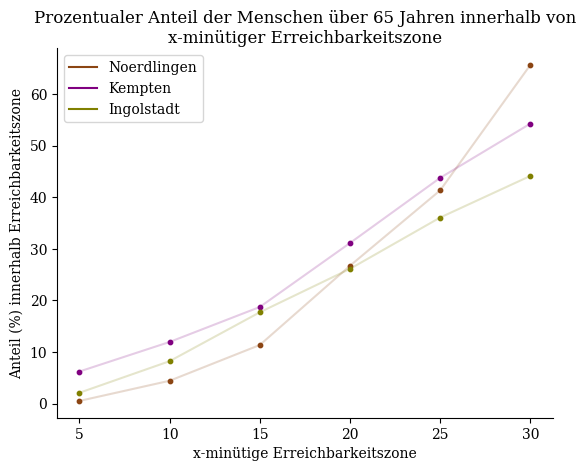

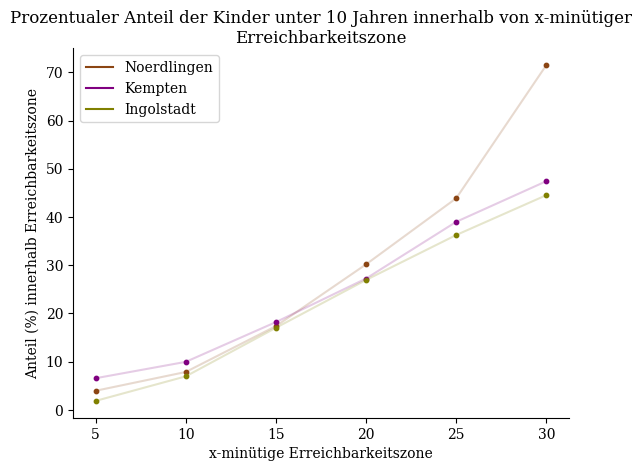

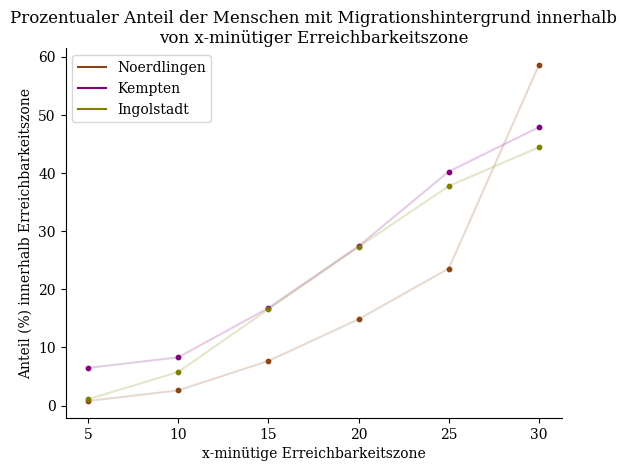

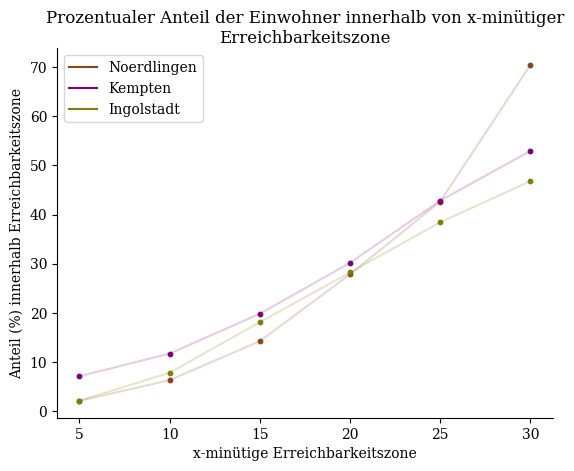

In [51]:
# Annahme: city_attribute_percentages_within_group, attribute_labels, cities, time_windows, percentage_Einwohner_dict, gruppen_anteile sind bereits geladen

# Definiere die Farben für die Städte
city_colors = {
    "Noerdlingen": "saddlebrown",
    "Kempten": "purple",
    "Ingolstadt": "olive",
}

# Erstelle Plots für die Attribute und die Einwohner
for data_source, title_prefix in [
    (gruppen_anteile, ""), # title_prefix wird hier nicht mehr benötigt
    (percentage_Einwohner_dict, ""),
]:
    # Wenn data_source gruppen_anteile ist, iteriere über die Attribute
    if data_source is gruppen_anteile:
        iterable = ['Menschen über 65', 'Kinder unter 10', 'Menschen mit Migrationshintergrund'] # Attribute aus gruppen_anteile
    # Wenn data_source percentage_dict ist, iteriere nur einmal
    else:
        iterable = [None]  # Dummy iterable for single plot

    for item in iterable:
        # Erstelle eine Figure und ein Axes-Objekt
        fig, ax = plt.subplots()

        legend_handles = [] # Liste für die Legendeneinträge

        # Schleife über die Städte
        for city in cities:
            # Extrahiere die Daten
            if data_source is gruppen_anteile:
                percentages = [data_source[city][item][time_window] for time_window in time_windows]
            else:
                # Check if the keys exist in the expected format:
                percentages = [data_source[city].get(f"{minutes}min", 0) for minutes in [5, 10, 15, 20, 25, 30]]
                # .get() with default value 0 is used to avoid KeyError

            # Titel dynamisch anpassen
            if data_source is gruppen_anteile:
                if item == 'Menschen über 65':
                    title = "Prozentualer Anteil der Menschen über 65 Jahren innerhalb von x-minütiger Erreichbarkeitszone"
                elif item == 'Kinder unter 10':
                    title = "Prozentualer Anteil der Kinder unter 10 Jahren innerhalb von x-minütiger Erreichbarkeitszone"
                elif item == 'Menschen mit Migrationshintergrund':
                    title = "Prozentualer Anteil der Menschen mit Migrationshintergrund innerhalb von x-minütiger Erreichbarkeitszone"
            else:
                title = "Prozentualer Anteil der Einwohner innerhalb von x-minütiger Erreichbarkeitszone" # Titel für Einwohner gesamt

           # Set the title with line breaks and vertical alignment
            ax.set_title(title, fontfamily='serif', loc='center', va='bottom', wrap=True)


            # Plotte die Daten mit angepasster Deckkraft
            line, = ax.plot(time_windows, percentages, label=city, color=city_colors[city], alpha=0.2)  # Linien mit 20% Deckkraft
            ax.scatter(time_windows, percentages, color=city_colors[city], alpha=1, s=10)  # Punkte mit 100% Deckkraft

            # Erstelle einen Legendeneintrag mit 100% Deckkraft
            label = "Nördlingen" if city == "Noerdlingen" else city
            legend_line = mlines.Line2D([], [], color=city_colors[city], label=city)
            legend_handles.append(legend_line) # Füge den Legendeneintrag zur Liste hinzu

        # Gestalte den Plot
        ax.set_xlabel("x-minütige Erreichbarkeitszone", fontfamily='serif', fontsize=10)
        ax.set_ylabel("Anteil (%) innerhalb Erreichbarkeitszone", fontfamily='serif', fontsize=10)
        ax.set_title(title, fontfamily='serif')

        # Füge die Legende mit den benutzerdefinierten Einträgen hinzu
        ax.legend(handles=legend_handles,  prop={'family': 'serif'})


        # Den Achsenrahmen nur links unten anzeigen
        ax.spines['right'].set_visible(False)  # Rechten Rahmen ausblenden
        ax.spines['top'].set_visible(False)    # Oberen Rahmen ausblenden

        ax.grid(True)

        # x-Achse nur mit den Zeitpunkten 5, 10, 15 und 20
        ax.set_xticks(time_windows)

        # Schriftart der Achsenskalen in Serif ändern
        ax.tick_params(axis='both', which='major', labelsize=10, labelfontfamily='serif')  # labelfontfamily für die Schriftart

        # Entferne die Achsenabschnitts-Verlängerungslinien
        plt.grid(False)

        # Zeige den Plot
        plt.show()

für plot:

Rahmen nur links und unten anzeigen:

```
ax.spines['right'].set_visible(False)  # Rechten Rahmen ausblenden
ax.spines['top'].set_visible(False)    # Oberen Rahmen ausblenden

ax.grid(True)
```

Gitterlinien innerhalb des Plots weg:

```
 plt.grid(False)
```

Beschriftung:

```
# Gestalte den Plot
ax.set_xlabel("Zeit (Minuten)", fontfamily='serif', fontsize=10)
ax.set_ylabel("Prozentualer Anteil (%)", fontfamily='serif', fontsize=10)
ax.set_title(title, fontfamily='serif')
```




2. Variante zeigt jetzt prozentualen Anteil von Menschen ü65,... die Cold Spot in x Minuten erreichen, an Menschen ü 65,... allgemein

**relative risk**: um wieviel Prozent höher ist das Risiko für Menschen ü65,... im Vergleich zu den Einwohnern allgemein,

bzw. hier: Das relative Risiko gibt an, wie viel wahrscheinlicher (oder unwahrscheinlicher) es ist, dass eine Person aus einer bestimmten Bevölkerungsgruppe im Vergleich zu einer zufällig ausgewählten Person aus der Gesamtbevölkerung einen Cold Spot innerhalb der gegebenen Zeit erreichen kann.

In [53]:
# Annahme: gruppen_anteile, percentage_Einwohner_dict, cities, time_windows, attributes, attribute_labels sind definiert

relative_risk = {}

for city in cities:
    relative_risk[city] = {}
    for attribute in attributes:
        relative_risk[city][attribute] = {}
        for time_window in time_windows:
            # Erreichbarkeit für die Bevölkerungsgruppe
            group_percentage = gruppen_anteile[city][attribute][time_window]

            # Erreichbarkeit für die Gesamtbevölkerung (aus percentage_Einwohner_dict)
            total_percentage = percentage_Einwohner_dict[city][f"{time_window}min"]

            # Relative Risiko berechnen (wenn total_percentage nicht 0 ist)
            if total_percentage != 0:
                risk = group_percentage / total_percentage
            else:
                risk = float("nan") # Oder einen anderen Wert für nicht definierte Risiken

            relative_risk[city][attribute][time_window] = risk

# Ausgabe des relativen Risikos
for city, attribute_risks in relative_risk.items():
    for attribute, time_risks in attribute_risks.items():
        for time_window, risk in time_risks.items():
            # Use the attribute directly instead of looking it up in attribute_labels
            print(f"Relatives Risiko für {attribute} in {city} "
                  f"innerhalb von {time_window} Minuten: {risk:.2f}")

Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 5 Minuten: 0.26
Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 10 Minuten: 0.70
Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 15 Minuten: 0.80
Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 20 Minuten: 0.96
Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 25 Minuten: 0.97
Relatives Risiko für Menschen über 65 in Noerdlingen innerhalb von 30 Minuten: 0.93
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 5 Minuten: 1.90
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 10 Minuten: 1.24
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 15 Minuten: 1.22
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 20 Minuten: 1.08
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 25 Minuten: 1.03
Relatives Risiko für Kinder unter 10 in Noerdlingen innerhalb von 30 Minuten: 1.02


In [56]:
# Erstelle eine Liste, um die Daten für die Tabelle zu speichern
table_data = []

for city in cities:
    for attribute in attributes:
        for time_window in time_windows:
            risk = relative_risk[city][attribute][time_window]
            # Use the attribute directly for the label in the table
            table_data.append([city, attribute, time_window, f"{risk:.2f}"])

# Erstelle einen Pandas DataFrame aus den Daten
df = pd.DataFrame(table_data, columns=["Stadt", "Bevölkerungsgruppe", "Zeitfenster (Minuten)", "Relatives Risiko:"])

# Gib die Tabelle aus
print(df)

# Optional: Speichere die Tabelle in einer CSV-Datei
df.to_csv("relatives_risiko.csv", index=False)

          Stadt                  Bevölkerungsgruppe  Zeitfenster (Minuten)  \
0   Noerdlingen                    Menschen über 65                      5   
1   Noerdlingen                    Menschen über 65                     10   
2   Noerdlingen                    Menschen über 65                     15   
3   Noerdlingen                    Menschen über 65                     20   
4   Noerdlingen                    Menschen über 65                     25   
5   Noerdlingen                    Menschen über 65                     30   
6   Noerdlingen                     Kinder unter 10                      5   
7   Noerdlingen                     Kinder unter 10                     10   
8   Noerdlingen                     Kinder unter 10                     15   
9   Noerdlingen                     Kinder unter 10                     20   
10  Noerdlingen                     Kinder unter 10                     25   
11  Noerdlingen                     Kinder unter 10             

==> laut Analyse haben alle exponierten Gruppen höhere Chance, den nächsten Cold Spot in x minuten zu erreichen

3. visuelle Darstellung: Karte mit Bevölkerungscluster, Cold Spots und Erreichbarkeitszonen